# Homework 1 (Total Points: 250) <a class="anchor" id="top"></a>


**Submission instructions**:
- The cells with the `# YOUR CODE HERE` denote that these sections are graded and you need to add your implementation.
- For Part 1: You can use the `nltk`, `NumPy`, and `matplotlib` libraries here. Other libraries, e.g., `gensim` or `scikit-learn`, may not be used. For Part 2: `gensim` is allowed in addition to the imported libraries in the next code cell
- Please use Python 3.6.5 and `pip install -r requirements.txt` to avoid version issues.
- The notebook you submit has to have the student ids, separated by underscores (E.g., `12341234_12341234_12341234_hw1.ipynb`).
- This will be parsed by a regexp, **so please double check your filename**.
- Only one member of each group has to submit the file (**please do not compress the .ipynb file when you will submit it**) to canvas.
- **Make sure to check that your notebook runs before submission**. A quick way to do this is to restart the kernel and run all the cells.  
- Do not change the number of arugments in the given functions.
- **Please do not delete/add new cells**. Removing cells **will** lead to grade deduction. 
- Note, that you are not allowed to use Google Colab.


**Learning Goals**:
- [Part 1, Term-based matching](#part1) (165 points):
    - Learn how to load a dataset and process it.
    - Learn how to implement several standard IR methods (TF-IDF, BM25, QL) and understand their weaknesses & strengths.
    - Learn how to evaluate IR methods.
- [Part 2, Semantic-based matching](#part2) (85 points):
    - Learn how to implement vector-space retrieval methods (LSI, LDA).
    - Learn how to use LSI and LDA for re-ranking.

    
**Resources**: 
- **Part 1**: Sections 2.3, 4.1, 4.2, 4.3, 5.3, 5.6, 5.7, 6.2, 7, 8 of [Search Engines: Information Retrieval in Practice](https://ciir.cs.umass.edu/downloads/SEIRiP.pdf)
- **Part 2**: [LSI - Chapter 18](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) from [Introduction to Information Retrieval](https://nlp.stanford.edu/IR-book/) book and the [original LDA paper](https://jmlr.org/papers/volume3/blei03a/blei03a.pdf)

In [1]:
# imports 
# TODO: Ensure that no additional library is imported in the notebook. 
# TODO: Only the standard library and the following libraries are allowed:
# TODO: You can also use unlisted classes from these libraries or standard libraries (such as defaultdict, Counter, ...).

import os
import zipfile
from functools import partial

import nltk
import requests
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from ipywidgets import widgets
from IPython.display import display, HTML
#from IPython.html import widgets
from collections import namedtuple

%matplotlib inline


# Part 1: Term-based Matching (165 points) <a class="anchor" id="part1"></a>

[Back to top](#top)

In the first part, we will learn the basics of IR from loading and preprocessing the material, to implementing some well known search algorithms, to evaluating the ranking performance of the implemented algorithms. We will be using the CACM dataset throughout the assignment. The CACM dataset is a collection of titles and abstracts from the journal CACM (Communication of the ACM).

Table of contents:
- [Section 1: Text Processing](#text_processing) (5 points)
- [Section 2: Indexing](#indexing) (10 points)
- [Section 3: Ranking](#ranking) (80 points)
- [Section 4: Evaluation](#evaluation) (40 points)
- [Section 5: Analysis](#analysis) (30 points)


---
## Section 1: Text Processing (5 points)<a class="anchor" id="text_processing"></a>

[Back to Part 1](#part1)

In this section, we will load the dataset and learn how to clean up the data to make it usable for an IR system. 
First, go through the implementation of the following functions:
- `read_cacm_docs`: Reads in the CACM documents.
- `read_queries`: Reads in the CACM queries.
- `load_stopwords`: Loads the stopwords.

The points of this section are earned for the following implementations:
- `tokenize` (3 points): Tokenizes the input text.
- `stem_token` (2 points): Stems the given token. 

We are using the [CACM dataset](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/), which is a small, classic IR dataset, composed of a collection of titles and abstracts from the journal CACM. It comes with relevance judgements for queries, so we can evaluate our IR system. 


---
### 1.1 Read the CACM documents


The following cell downloads the dataset and unzips it to a local directory.

In [2]:
def download_dataset():
    folder_path = os.environ.get("IR1_DATA_PATH")
    if not folder_path:
        folder_path = "./datasets/"
    os.makedirs(folder_path, exist_ok=True)
    
    file_location = os.path.join(folder_path, "cacm.zip")
    
    # download file if it doesn't exist
    if not os.path.exists(file_location):
        
        url = "https://surfdrive.surf.nl/files/index.php/s/M0FGJpX2p8wDwxR/download"

        with open(file_location, "wb") as handle:
            print(f"Downloading file from {url} to {file_location}")
            response = requests.get(url, stream=True)
            for data in tqdm(response.iter_content()):
                handle.write(data)
            print("Finished downloading file")
    
    if not os.path.exists(os.path.join(folder_path, "train.txt")):
        
        # unzip file
        with zipfile.ZipFile(file_location, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
download_dataset()

---

You can see a brief description of each file in the dataset by looking at the README file:

In [3]:
##### Read the README file 
with open ("./datasets/README","r") as file:
    readme = file.read()
    print(readme)
#####

Files in this directory with sizes:
          0 Jun 19 21:01 README

    2187734 Jun 19 20:55 cacm.all              text of documents
        626 Jun 19 20:58 cite.info             key to citation info
                                                (the X sections in cacm.all)
       2668 Jun 19 20:55 common_words           stop words used by smart
       2194 Jun 19 20:55 make_coll*             shell script to make collection
       1557 Jun 19 20:55 make_coll_term*        ditto (both useless without
                                                smart system)
       9948 Jun 19 20:55 qrels.text             relation giving
                                                    qid did 0 0
                                                to indicate dument did is
                                                relevant to query qid
      13689 Jun 19 20:55 query.text             Original text of the query



---
We are interested in 4 files:
- `cacm.all` : Contains the text for all documents. Note that some documents do not have abstracts available
- `query.text` : The text of all queries
- `qrels.text` : The relevance judgements
- `common_words` : A list of common words. This may be used as a collection of stopwords

In [4]:
##### The first 45 lines of the CACM dataset forms the first record
# We are interested only in 3 fields. 
# 1. the '.I' field, which is the document id
# 2. the '.T' field (the title) and
# 3. the '.W' field (the abstract, which may be absent)
with open ("./datasets/cacm.all","r") as file:
    cacm_all = "".join(file.readlines()[:45])
    print(cacm_all)
#####

.I 1
.T
Preliminary Report-International Algebraic Language
.B
CACM December, 1958
.A
Perlis, A. J.
Samelson,K.
.N
CA581203 JB March 22, 1978  8:28 PM
.X
100	5	1
123	5	1
164	5	1
1	5	1
1	5	1
1	5	1
205	5	1
210	5	1
214	5	1
1982	5	1
398	5	1
642	5	1
669	5	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
165	6	1
196	6	1
196	6	1
1273	6	1
1883	6	1
324	6	1
43	6	1
53	6	1
91	6	1
410	6	1
3184	6	1



---

The following function reads the `cacm.all` file. Note that each document has a variable number of lines. The `.I` field denotes a new document:

In [5]:
def read_cacm_docs(root_folder = "./datasets/"):
    """
        Reads in the CACM documents. The dataset is assumed to be in the folder "./datasets/" by default
        Returns: A list of 2-tuples: (doc_id, document), where 'document' is a single string created by 
            appending the title and abstract (separated by a "\n"). 
            In case the record doesn't have an abstract, the document is composed only by the title
    """
    with open(os.path.join(root_folder, "cacm.all")) as reader:
        lines = reader.readlines()
    
    doc_id, title, abstract = None, None, None
    
    docs = []
    line_idx = 0
    while line_idx < len(lines):
        line = lines[line_idx]
        if line.startswith(".I"):
            if doc_id is not None:
                docs.append((doc_id, title, abstract))
                doc_id, title, abstract = None, None, None
            
            doc_id = line.split()[-1]
            line_idx += 1
        elif line.startswith(".T"):
            # start at next line
            line_idx += 1
            temp_lines = []
            # read till next '.'
            while not lines[line_idx].startswith("."):
                temp_lines.append(lines[line_idx].strip("\n"))
                line_idx += 1
            title = "\n".join(temp_lines).strip("\n")
        elif line.startswith(".W"):
            # start at next line
            line_idx += 1
            temp_lines = []
            # read till next '.'
            while not lines[line_idx].startswith("."):
                temp_lines.append(lines[line_idx].strip("\n"))
                line_idx += 1
            abstract = "\n".join(temp_lines).strip("\n")
        else:
            line_idx += 1
    
    docs.append((doc_id, title, abstract))
    
    p_docs = []
    for (did, t, a) in docs:
        if a is None:
            a = ""
        p_docs.append((did, t + "\n" + a))
    return p_docs


In [6]:
##### Function check
docs = read_cacm_docs()

assert isinstance(docs, list)
assert len(docs) == 3204, "There should be exactly 3204 documents"

unzipped_docs = list(zip(*docs))
assert np.sum(np.array(list(map(int,unzipped_docs[0])))) == 5134410

##### 

---
### 1.2 Read the CACM queries

Next, let us read the queries. They are formatted similarly:

In [7]:
##### The first 15 lines of 'query.text' has 2 queries
# We are interested only in 2 fields. 
# 1. the '.I' - the query id
# 2. the '.W' - the query
!head -15 ./datasets/query.text
#####

.I 1
.W
 What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
.N
 1. Richard Alexander, Comp Serv, Langmuir Lab (TSS)
 
.I 2
.W
 I am interested in articles written either by Prieve or Udo Pooch
.A
Prieve, B.
Pooch, U.
.N
 2. Richard Alexander, Comp Serv, Langmuir Lab (author = Pooch or Prieve)


---

The following function reads the `query.text` file:

In [8]:
def read_queries(root_folder = "./datasets/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" by default
        Returns: A list of 2-tuples: (query_id, query)
    """
    with open(os.path.join(root_folder, "query.text")) as reader:
        lines = reader.readlines()
    
    query_id, query = None, None
    
    queries = []
    line_idx = 0
    while line_idx < len(lines):
        line = lines[line_idx]
        if line.startswith(".I"):
            if query_id is not None:
                queries.append((query_id, query))
                query_id, query = None, None
    
            query_id = line.split()[-1]
            line_idx += 1
        elif line.startswith(".W"):
            # start at next line
            line_idx += 1
            temp_lines = []
            # read till next '.'
            while not lines[line_idx].startswith("."):
                temp_lines.append(lines[line_idx].strip("\n"))
                line_idx += 1
            query = "\n".join(temp_lines).strip("\n")
        else:
            line_idx += 1
    
    queries.append((query_id, query))
    return queries


In [9]:
##### Function check
queries = read_queries()

assert isinstance(queries, list)
assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"

unzipped_queries = list(zip(*queries))
assert np.sum(np.array(list(map(int,unzipped_queries[0])))) == 2080

##### 

---
### 1.3 Read the stop words

We use the common words stored in `common_words`:

In [10]:
##### Read the stop words file 
!head ./datasets/common_words
##### Read the README file 

a
about
above
accordingly
across
after
afterwards
again
against
all


---

The following function reads the `common_words` file (For better coverage, we try to keep them in lowercase):

In [11]:
def load_stopwords(root_folder = "./datasets/"):
    """
        Loads the stopwords. The dataset is assumed to be in the folder "./datasets/" by default
        Output: A set of stopwords
    """
    with open(os.path.join(root_folder, "common_words")) as reader:
        lines = reader.readlines()
    stopwords = set([l.strip().lower() for l in lines])
    return stopwords


In [12]:
##### Function check
stopwords = load_stopwords()

assert isinstance(stopwords, set)
assert len(stopwords) == 428, "There should be exactly 428 stop words"

assert np.sum(np.array(list(map(len,stopwords)))) == 2234

##### 


---
### 1.4 Tokenization (3 points)

We can now write some basic text processing functions. 
A first step is to tokenize the text. 

**Note**: Use the  `WordPunctTokenizer` available in the `nltk` library:

In [13]:
# TODO: Implement this! (4 points)
from nltk.tokenize import WordPunctTokenizer

def tokenize(text):
    """
        Tokenizes the input text. Use the WordPunctTokenizer
        Input: text - a string
        Output: a list of tokens
    """
    # YOUR CODE HERE
    tk = WordPunctTokenizer()
    return tk.tokenize(text)

In [14]:
##### Function check
text = "the quick brown fox jumps over the lazy dog"
tokens = tokenize(text)

assert isinstance(tokens, list)
assert len(tokens) == 9

print(tokens)
# output: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
#####

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


---
### 1.5 Stemming (2 points)

Write a function to stem tokens. 
Again, you can use the nltk library for this:

In [15]:
# TODO: Implement this! (3 points)
from nltk.stem.porter import PorterStemmer

def stem_token(token):
    """
        Stems the given token using the PorterStemmer from the nltk library
        Input: a single token
        Output: the stem of the token
    """
    # YOUR CODE HERE
    st = PorterStemmer()
    return st.stem(token)

In [16]:
##### Function check

assert stem_token('owned') == 'own'
assert stem_token('itemization') == 'item'
#####

---
### 1.6 Summary

The following function puts it all together. Given an input string, this functions tokenizes and processes it according to the flags that you set.

In [17]:
#### Putting it all together
def process_text(text, stem=False, remove_stopwords=False, lowercase_text=False):
    
    tokens = []
    for token in tokenize(text):
        if remove_stopwords and token.lower() in stopwords:
            continue
        if stem:
            token = stem_token(token)
        if lowercase_text:
            token = token.lower()
        tokens.append(token)

    return tokens
#### 

---

Let's create two sets of preprocessed documents.
We can process the documents and queries according to these two configurations:

In [18]:
# In this configuration:
# Don't preprocess the text, except to tokenize 
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
} 


# In this configuration:
# Preprocess the text, stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True, 
} 

####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, **config_2)))

####

--- 

## Section 2: Indexing (10 points)<a class="anchor" id="indexing"></a>

[Back to Part 1](#part1)



A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


### 2.1 Term Frequency-index (10 points)
In this assignment, we will be using an index created in memory since our dataset is tiny. To get started, build a simple index that maps each `token` to a list of `(doc_id, count)` where `count` is the count of the `token` in `doc_id`.
For consistency, build this index using a python dictionary.
    
Now, implement a function to build an index:

In [19]:
# TODO: Implement this! (10 points)
from collections import Counter, defaultdict

def build_tf_index(documents):
    """
        Build an inverted index (with counts). The output is a dictionary which takes in a token
        and returns a list of (doc_id, count) where 'count' is the count of the 'token' in 'doc_id'
        Input: a list of documents - (doc_id, tokens) 
        Output: An inverted index implemented within a pyhton dictionary: [token] -> [(doc_id, token_count)]
    """
    # YOUR CODE HERE
    index = defaultdict(list)
    for doc in documents:
        count = Counter(doc[1])
        for key, value in dict(count).items():
            index[key].append((doc[0], value))
    
    return index   

---
Now we can build indexed documents and preprocess the queries based on the two configurations:

In [20]:
#### Indexed documents based on the two configs

# Create the 2 indices
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

# This function returns the tf_index of the corresponding config
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: tf_index_1,
        2: tf_index_2
    }[index_set]

####
#### Preprocessed query based on the two configs

# This function preprocesses the text given the index set, according to the specified config
def preprocess_query(text, index_set):
    assert index_set in {1, 2}
    if index_set == 1:
        return process_text(text, **config_1)
    elif index_set == 2:
        return process_text(text, **config_2)

#### 

In [21]:
##### Function check

assert isinstance(tf_index_1, dict)

assert isinstance(tf_index_1['computer'], list)
print('sample tf index for computer:', tf_index_1['computer'][:10])

assert isinstance(tf_index_1['examples'], list)
print('sample tf index for examples:', tf_index_1['examples'][:10])
#### 

sample tf index for computer: [('4', 1), ('7', 1), ('10', 1), ('13', 1), ('19', 1), ('22', 1), ('23', 1), ('37', 1), ('40', 3), ('41', 1)]
sample tf index for examples: [('111', 1), ('320', 1), ('644', 1), ('691', 1), ('727', 1), ('848', 1), ('892', 1), ('893', 1), ('1049', 1), ('1051', 1)]


In [22]:
##### Function check

assert isinstance(tf_index_2, dict)

assert isinstance(tf_index_2['computer'], list)
print('sample tf index for computer:', tf_index_1['computer'][:10])

assert isinstance(tf_index_2['examples'], list)
print('sample tf index for examples:', tf_index_2['examples'][:10])
#### 

sample tf index for computer: [('4', 1), ('7', 1), ('10', 1), ('13', 1), ('19', 1), ('22', 1), ('23', 1), ('37', 1), ('40', 3), ('41', 1)]
sample tf index for examples: []



---
## Section 3: Ranking  (80 points) <a class="anchor" id="ranking"></a>

[Back to Part 1](#part1)

Now that we have cleaned and processed our dataset, we can start building simple IR systems. 

For now, we consider *simple* IR systems, which involve computing scores from the tokens present in the document/query. More advanced methods are covered in later assignments.

We will implement the following methods in this section:
- [Section 3.1: Bag of Words](#bow) (10 points)
- [Section 3.2: TF-IDF](#tfidf) (15 points)
- [Section 3.3: Query Likelihood Model](#qlm) (35 points)
- [Section 3.4: BM25](#bm25) (20 points)

*All search functions should be able to handle multiple words queries.*

**Scoring policy:**
Your implementations in this section are scored based on the expected performance of your ranking functions.
You will get a full mark if your implementation meets the expected performance (measured by some evaluation metric).
Otherwise, you may get partial credit.
For example, if your *Bag of words* ranking function has 60% of expected performance, you will get 6 out of 10.

--- 

### Section 3.1: Bag of Words (10 points)<a class="anchor" id="bow"></a>

Probably the simplest IR model is the Bag of Words (BOW) model.
Implement a function that scores and ranks all the documents against a query using this model.   

- For consistency, you should use the count of the token and **not** the binary indicator.
- Use `float` type for the scores (even though the scores are integers in this case).
- No normalization of the scores is necessary, as the ordering is what we are interested in.
- If two documents have the same score, they can have any ordering: you are not required to disambiguate.


In [23]:
# TODO: Implement this! (10 points)
import operator

def bow_search(query, index_set):
    """
        Perform a search over all documents with the given query. 
        Note: You have to use the `get_index` function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query. 
    """
    index = get_index(index_set)
    processed_query = preprocess_query(query, index_set)
    
    # YOUR CODE HERE
    score = defaultdict(int)
    for word in processed_query:
        for doc_id, token_count in index[word]:
            score[doc_id] += float(token_count)
    
    sorted_score = dict(sorted(score.items(), key=operator.itemgetter(1),reverse=True))
    return list(sorted_score.items())

In [24]:
#### Function check

test_bow = bow_search("how to implement bag of words search", index_set=1)[:5]
assert isinstance(test_bow, list)
assert len(test_bow[0]) == 2
assert isinstance(test_bow[0][0], str)
assert isinstance(test_bow[0][1], float)

#### 

In [25]:

docs_by_id = dict(docs)
def print_results(docs, len_limit=50):    
    for i, (doc_id, score) in enumerate(docs):
        doc_content = docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        print(f"Rank {i}({score:.2}): {doc_content}")

test_bow_2 = bow_search("computer search word", index_set=2)[:5]
print(f"BOW Results:")
print_results(test_bow_2)


BOW Results:
Rank 0(1.3e+01): On Computing The Fast Fourier Transform\nCooley an...
Rank 1(1.2e+01): Variable Length Tree Structures Having Minimum Ave...
Rank 2(1.1e+01): A Modular Computer Sharing System\nAn alternative ...
Rank 3(1e+01): PEEKABIT, Computer Offspring of Punched\nCard PEEK...
Rank 4(9.0): Computer Simulation-Discussion of the\nTechnique a...


In [26]:

test_bow_1 = bow_search("computer search word", index_set=1)[:5]
print(f"BOW Results:")
print_results(test_bow_1)


BOW Results:
Rank 0(9.0): CURRICULUM 68 -- Recommendations for Academic\nPro...
Rank 1(9.0): Variable Length Tree Structures Having Minimum Ave...
Rank 2(7.0): Computer Formulation of the Equations of Motion Us...
Rank 3(7.0): The Effects of Multiplexing on a Computer-Communic...
Rank 4(6.0): Optimizing Bit-time Computer Simulation\nA major c...


In [27]:
print('top-5 docs for index1:', list(zip(*test_bow_1[:5]))[0])
print('top-5 docs for index2:', list(zip(*test_bow_2[:5]))[0])


top-5 docs for index1: ('1771', '1936', '1543', '2535', '678')
top-5 docs for index2: ('1525', '1936', '1844', '1700', '1366')



---

### Section 3.2: TF-IDF (15 points) <a class="anchor" id="tfidf"></a>

Before we implement the tf-idf scoring functions, let's first write a function to compute the document frequencies of all words.  

#### 3.2.1 Document frequency (5 points)
Compute the document frequencies of all tokens in the collection. 
Your code should return a dictionary with tokens as its keys and the number of documents containing the token as values.
For consistency, the values should have `int` type.

In [28]:
# TODO: Implement this! (5 points)
def compute_df(documents):
    """
        Compute the document frequency of all terms in the vocabulary
        Input: A list of documents
        Output: A dictionary with {token: document frequency (int)}
    """
    # YOUR CODE HERE
    freq = defaultdict(int)
    for doc in documents:
        for word in set(doc):
            freq[word] += 1
    return freq

In [29]:
#### Compute df based on the two configs

# get the document frequencies of each document
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

def get_df(index_set):
    assert index_set in {1, 2}
    return {
        1: df_1,
        2: df_2
    }[index_set]
####

In [30]:
#### Function check

print(df_1['computer'])
print(df_2['computer'])
####

597
11


---
#### 3.2.2 TF-IDF search (10 points)
Next, implement a function that computes a tf-idf score, given a query.
Use the following formulas for TF and IDF:

$$ TF=\log (1 + f_{d,t}) $$

$$ IDF=\log (\frac{N}{n_t})$$

where $f_{d,t}$ is the frequency of token $t$ in document $d$, $N$ is the number of total documents and $n_t$ is the number of documents containing token $t$.

**Note:** your implementation will be auto-graded assuming you have used the above formulas.


In [31]:
# TODO: Implement this! (10 points)
def tfidf_search(query, index_set):
    """
        Perform a search over all documents with the given query using tf-idf. 
        Note #1: You have to use the `get_index` (and the `get_df`) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    df = get_df(index_set)
    processed_query = preprocess_query(query, index_set)
    
    N = len(docs)
    # YOUR CODE HERE
    tf_idf = defaultdict(int)
    for word in processed_query:
        idf = np.log(N / (df[word]+1e-42))
        for doc_id, token_count in index[word]:
            tf = np.log(1 + token_count)
            tf_idf[doc_id] += tf * idf
            
    sorted_tf_idf = dict(sorted(tf_idf.items(), key=operator.itemgetter(1),reverse=True))
    return list(sorted_tf_idf.items())

In [32]:

#### Function check
test_tfidf = tfidf_search("how to implement tf idf search", index_set=1)[:5]
assert isinstance(test_tfidf, list)
assert len(test_tfidf[0]) == 2
assert isinstance(test_tfidf[0][0], str)
assert isinstance(test_tfidf[0][1], float)

####

In [33]:

test_tfidf_2 = tfidf_search("computer word search", index_set=2)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf_2)


TFIDF Results:
Rank 0(1.3e+01): PEEKABIT, Computer Offspring of Punched\nCard PEEK...
Rank 1(9.8): Variable Length Tree Structures Having Minimum Ave...
Rank 2(8.2): A Stochastic Approach to the Grammatical Coding of...
Rank 3(8.1): Full Table Quadratic Searching for Scatter Storage...
Rank 4(7.6): Use of Tree Structures for Processing Files\nIn da...


In [34]:

test_tfidf_1 = tfidf_search("computer word search", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf_1)


TFIDF Results:
Rank 0(9.4): Variable Length Tree Structures Having Minimum Ave...
Rank 1(7.4): On the Feasibility of Voice Input to\nan On-line C...
Rank 2(7.3): Median Split Trees: A Fast Lookup Technique for Fr...
Rank 3(7.0): Execution Time Requirements for Encipherment Progr...
Rank 4(7.0): Storage and Search Properties of a Tree-Organized ...


In [35]:

print('top-5 docs for index1 with BOW search:', list(zip(*test_bow_1[:5]))[0])
print('top-5 docs for index2 with BOW search:', list(zip(*test_bow_2[:5]))[0])
print('top-5 docs for index1 with TF-IDF search:', list(zip(*test_tfidf_1[:5]))[0])
print('top-5 docs for index2 with TF-IDF search:', list(zip(*test_tfidf_2[:5]))[0])



top-5 docs for index1 with BOW search: ('1771', '1936', '1543', '2535', '678')
top-5 docs for index2 with BOW search: ('1525', '1936', '1844', '1700', '1366')
top-5 docs for index1 with TF-IDF search: ('1936', '2054', '3041', '2620', '944')
top-5 docs for index2 with TF-IDF search: ('1700', '1936', '1235', '2018', '849')


--- 

### Section 3.3: Query Likelihood Model (35 points) <a class="anchor" id="qlm"></a>

In this section, you will implement a simple query likelihood model. 


#### 3.3.1 Naive QL (15 points)

First, let us implement a naive version of a QL model, assuming a multinomial unigram language model (with a uniform prior over the documents). 



In [36]:
#### Document length for normalization

def doc_lengths(documents):
    doc_lengths = {doc_id:len(doc) for (doc_id, doc) in documents}
    return doc_lengths

doc_lengths_1 = doc_lengths(doc_repr_1)
doc_lengths_2 = doc_lengths(doc_repr_2)

def get_doc_lengths(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_lengths_1,
        2: doc_lengths_2
    }[index_set]
####

In [37]:
# TODO: Implement this! (15 points)
def naive_ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a naive QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    processed_query = preprocess_query(query, index_set)
    # YOUR CODE HERE
    first_pass = set()
    naive_ql = defaultdict(lambda: 1.)
    for word in processed_query:
        visited_docs = set()
        for doc_id, token_count in index[word]:
            visited_docs.add(doc_id)
            naive_ql[doc_id] *= token_count/doc_lengths[doc_id]
        if not len(first_pass):
            first_pass = visited_docs
        for doc_id in naive_ql.keys():
            if doc_id not in visited_docs:
                naive_ql[doc_id] = 0
    
    for doc_id in naive_ql.keys():
        if doc_id not in first_pass:
            naive_ql[doc_id] = 0
        
    sorted_naive_ql = dict(sorted(naive_ql.items(), key=operator.itemgetter(1),reverse=True))
    return list(sorted_naive_ql.items())


In [38]:
#### Function check
test_naiveql = naive_ql_search("report", index_set=1)[:5]
print(f"Naive QL Results:")
print_results(test_naiveql)
####

Naive QL Results:
Rank 0(0.2): A Report Writer For COBOL...
Rank 1(0.2): A CRT Report Generating System...
Rank 2(0.17): Preliminary Report-International Algebraic Languag...
Rank 3(0.17): Supplement to the ALGOL 60 Report...
Rank 4(0.14): ALGOL Sub-Committee Report - Extensions...


In [39]:
#### Please do not change this. This cell is used for grading.

In [40]:
#### Please do not change this. This cell is used for grading.

In [41]:
#### Please do not change this. This cell is used for grading.

In [42]:
#### Please do not change this. This cell is used for grading.

---
#### 3.3.2 QL (20 points)
Now, let's implement a QL model that handles the issues with the naive version. In particular, you will implement a QL model with Jelinek-Mercer Smoothing. That means an interpolated score is computed per word - one term is the same as the previous naive version, and the second term comes from a unigram language model. In addition, you should accumulate the scores by summing the **log** (smoothed) probability which leads to better numerical stability.

In [43]:
# TODO: Implement this! (20 points)
# YOUR CODE HERE
def ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a QL model 
        with Jelinek-Mercer Smoothing (set smoothing=0.1). 
        
        
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        

        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    processed_query = preprocess_query(query, index_set)
    
    # YOUR CODE HERE
    smoothing = 0.1
    ql = defaultdict(float)
    cl = sum(doc_lengths.values())

    term_freq_in_corpus = defaultdict(float)
    term_freq_in_corpus = {word:sum(token_count for doc_id, token_count in index[word]) for word in processed_query}

    for word in processed_query:
        if not index[word]:
            continue

        prob_term = defaultdict(float)
        for doc_id, token_count in index[word]:
            prob_term[doc_id] = (1-smoothing)*token_count/doc_lengths[doc_id]
        
        smoothing_term = smoothing*term_freq_in_corpus[word]/cl
        for doc_id in doc_lengths.keys():
            ql[doc_id] += np.log10(prob_term[doc_id]+smoothing_term)

    sorted_ql = dict(sorted(ql.items(), key=operator.itemgetter(1),reverse=True))
    return list(sorted_ql.items())
    

In [44]:
#### Function check
test_ql_results = ql_search("report", index_set=1)[:5]
print_results(test_ql_results)
print()
test_ql_results_long = ql_search("report " * 10, index_set=1)[:5]
print_results(test_ql_results_long)
####

Rank 0(-0.74): A Report Writer For COBOL...
Rank 1(-0.74): A CRT Report Generating System...
Rank 2(-0.82): Preliminary Report-International Algebraic Languag...
Rank 3(-0.82): Supplement to the ALGOL 60 Report...
Rank 4(-0.89): ALGOL Sub-Committee Report - Extensions...

Rank 0(-7.4): A Report Writer For COBOL...
Rank 1(-7.4): A CRT Report Generating System...
Rank 2(-8.2): Preliminary Report-International Algebraic Languag...
Rank 3(-8.2): Supplement to the ALGOL 60 Report...
Rank 4(-8.9): ALGOL Sub-Committee Report - Extensions...


In [45]:
#### Please do not change this. This cell is used for grading.

In [46]:
#### Please do not change this. This cell is used for grading.

In [47]:
#### Please do not change this. This cell is used for grading.

In [48]:
#### Please do not change this. This cell is used for grading.

--- 

### Section 3.4: BM25 (20 points) <a class="anchor" id="bm25"></a>

In this section, we will implement the BM25 scoring function. 


In [49]:
# TODO: Implement this! (20 points)
def bm25_search(query, index_set):
    """
        Perform a search over all documents with the given query using BM25. Use k_1 = 1.5 and b = 0.75
        Note #1: You have to use the `get_index` (and `get_doc_lengths`) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    index = get_index(index_set)
    df = get_df(index_set)
    doc_lengths = get_doc_lengths(index_set)
    processed_query = preprocess_query(query, index_set)
    
    # YOUR CODE HERE
    k_1 = 1.5
    b = 0.75
    N = len(docs)
    dl_avg = sum(doc_lengths.values())/len(doc_lengths)
    bm25 = defaultdict(int)
    for word in processed_query:
        term_1 = np.log(N/(df[word]+1e-42))
        for doc_id, token_count in index[word]:
            term_2 = (k_1+1)*token_count
            term_3 = k_1*((1-b)+b*doc_lengths[doc_id]/dl_avg)+token_count
            bm25[doc_id] += (term_1*term_2/term_3)
        
    
    sorted_bm25 = dict(sorted(bm25.items(), key=operator.itemgetter(1),reverse=True))
    return list(sorted_bm25.items())

In [50]:
#### Function check
test_bm25_results = bm25_search("report", index_set=1)[:5]
print_results(test_bm25_results)
####

Rank 0(6.7): A Report Writer For COBOL...
Rank 1(6.7): A CRT Report Generating System...
Rank 2(6.6): Preliminary Report-International Algebraic Languag...
Rank 3(6.6): Supplement to the ALGOL 60 Report...
Rank 4(6.5): ALGOL Sub-Committee Report - Extensions...


In [51]:
#### Please do not change this. This cell is used for grading.

In [52]:
#### Please do not change this. This cell is used for grading.

In [53]:
#### Please do not change this. This cell is used for grading.

In [54]:
#### Please do not change this. This cell is used for grading.


---

### 3.5. Test Your Functions

The widget below allows you to play with the search functions you've written so far. Use this to test your search functions and ensure that they work as expected.

In [55]:
#### Highlighter function
# class for results
ResultRow = namedtuple("ResultRow", ["doc_id", "snippet", "score"])
# doc_id -> doc
docs_by_id = dict((d[0], d[1]) for d in docs)

def highlight_text(document, query, tol=17):
    import re
    tokens = tokenize(query)
    regex = "|".join(f"(\\b{t}\\b)" for t in tokens)
    regex = re.compile(regex, flags=re.IGNORECASE)
    output = ""
    i = 0
    for m in regex.finditer(document):
        start_idx = max(0, m.start() - tol)
        end_idx = min(len(document), m.end() + tol)
        output += "".join(["...",
                        document[start_idx:m.start()],
                        "<strong>",
                        document[m.start():m.end()],
                        "</strong>",
                        document[m.end():end_idx],
                        "..."])
    return output.replace("\n", " ")


def make_results(query, search_fn, index_set):
    results = []
    for doc_id, score in search_fn(query, index_set):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results
####

In [56]:
# TODO: Set this to the function you want to test!
# this function should take in a query (string)
# and return a sorted list of (doc_id, score) 
# with the most relevant document in the first position
search_fn = bm25_search
index_set = 1

text = widgets.Text(description="Search Bar", width=200)
display(text)

def handle_submit(sender):
    print(f"Searching for: '{sender.value}'")
    
    results = make_results(sender.value, search_fn, index_set)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit)

Text(value='', description='Search Bar')

---

## Section 4: Evaluation (40 points) <a class="anchor" id="evaluation"></a>

[Back to Part 1](#part1)

In order to analyze the effectiveness of retrieval algorithms, we first have to learn how to evaluate such a system. In particular, we will work with offline evaluation metrics. These metrics are computed on a dataset with known relevance judgements.

Implement the following evaluation metrics. 

1. Precision (7 points)
2. Recall (7 points)
3. Mean Average Precision (13 points)
4. Expected Reciprocal Rank (13 points)

---
### 4.1 Read relevance labels

Let's take a look at the `qrels.text` file, which contains the ground truth relevance scores. The relevance labels for CACM are binary - either 0 or 1. 


In [57]:
!head ./datasets/qrels.text

01 1410  0 0
01 1572  0 0
01 1605  0 0
01 2020  0 0
01 2358  0 0
02 2434  0 0
02 2863  0 0
02 3078  0 0
03 1134  0 0
03 1613  0 0


---

The first column is the query_id and the second column is the document_id. We can safely ignore the 3rd and 4th columns.

In [58]:
# YOUR CODE HERE
def read_qrels(root_folder = "./datasets/"):
    """
        Reads the qrels.text file. 
        Output: A dictionary: query_id -> [list of relevant documents]
    """
    with open(os.path.join(root_folder, "qrels.text")) as reader:
        lines = reader.readlines()
    
    from collections import defaultdict
    relevant_docs = defaultdict(set)
    for line in lines:
        query_id, doc_id, _, _ = line.split()
        relevant_docs[str(int(query_id))].add(doc_id)
    return relevant_docs

In [59]:
#### Function check
qrels = read_qrels()

assert len(qrels) == 52, "There should be 52 queries with relevance judgements"
assert sum(len(j) for j in qrels.values()) == 796, "There should be a total of 796 Relevance Judgements"

assert np.min(np.array([len(j) for j in qrels.values()])) == 1
assert np.max(np.array([len(j) for j in qrels.values()])) == 51

####

---
**Note:** For a given query `query_id`, you can assume that documents *not* in `qrels[query_id]` are not relevant to `query_id`. 


---
### 4.2 Precision (7 points)
Implement the `precision@k` metric:

In [60]:
# TODO: Implement this! (7 points)
def precision_k(results, relevant_docs, k):
    """
        Compute Precision@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Precision@K
    """
    if k > len(results):
        k = len(results)
    # YOUR CODE HERE
    relevant = 0
    for document_id, score in results[:k]:
        if document_id in relevant_docs:
            relevant += 1
    return relevant/k

In [61]:

#### Function check
qid = queries[0][0]
qtext = queries[0][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
precision = precision_k(results, qrels[qid], 10)
print(f'precision@10 = {precision}')
####

query: What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
precision@10 = 0.2


---
### 4.3 Recall (7 points)
Implement the `recall@k` metric:

In [62]:
# TODO: Implement this! (7 points)
def recall_k(results, relevant_docs, k):
    """
        Compute Recall@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Recall@K
    """
    # YOUR CODE HERE
    if k > len(results):
        k = len(results)
    relevant = 0
    for document_id, score in results[:k]:
        if document_id in relevant_docs:
            relevant += 1
    return relevant/len(relevant_docs)

In [63]:
#### Function check
qid = queries[10][0]
qtext = queries[10][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
recall = recall_k(results, qrels[qid], 10)
print(f'recall@10 = {recall}')
####

query: SETL, Very High Level Languages
recall@10 = 0.3157894736842105


---
### 4.4 Mean Average Precision (13 points)
Implement the `map` metric:

In [64]:
# TODO: Implement this! (12 points)
def average_precision(results, relevant_docs):
    """
        Compute Average Precision (for a single query - the results are 
        averaged across queries to get MAP in the next few cells)
        Hint: You can use the recall_k and precision_k functions here!
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: Average Precision
    """
    # YOUR CODE HERE
    pre_scores = []
    relevant = 0
    for i, (document_id, _) in enumerate(results):
        if document_id in relevant_docs:
            relevant += 1
            pre_scores.append(relevant / (i+1))
    if len(pre_scores) != 0:
        return np.mean(pre_scores)
    else:
        return 0

In [65]:
#### Function check
qid = queries[20][0]
qtext = queries[20][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
mean_ap = average_precision(results, qrels[qid])
print(f'MAP = {mean_ap}')
####

query: computational complexity, intractability, class-complete reductions,
algorithms and efficiency
MAP = 0.1724040411055945


---
### 4.5 Expected Reciprocal Rank (13 points)
Implement the `err` metric:

In [66]:
# TODO: Implement this! (12 points)
def err(results, relevant_docs):
    """
        Compute the expected reciprocal rank.
        Hint: https://dl.acm.org/doi/pdf/10.1145/1645953.1646033?download=true
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: ERR
        
    """
    # YOUR CODE HERE
    err_score = 0
    p_user_has_not_stoped = 1
    for index, (doc_id, _) in enumerate(results):
        p_result_relevant = 0.5 if doc_id in relevant_docs else 0
        err_score += p_user_has_not_stoped * p_result_relevant / (index+1)
        p_user_has_not_stoped = p_user_has_not_stoped * (1-p_result_relevant)
    return err_score

In [67]:
#### Function check
qid = queries[30][0]
qtext = queries[30][1]
print(f'query:{qtext}')
results = bm25_search(qtext, 2)
ERR = err(results, qrels[qid])
print(f'ERR = {ERR}')
####

query: I'd like to find articles describing the use of singular value decomposition
in digital image processing.  Applications include finding approximations
to the original image and restoring images that are subject to noise. An
article on the subject is H.C. Andrews and C.L. Patterson "Outer product
expansions and their uses in digital image processing", American Mathematical
Monthly, vol. 82.
ERR = 0.625


---
### 4.6 Evaluate Search Functions

Let's define some metrics@k using [partial functions](https://docs.python.org/3/library/functools.html#functools.partial)

In [68]:
#### metrics@k functions

recall_at_1 = partial(recall_k, k=1)
recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
precision_at_1 = partial(precision_k, k=1)
precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)


list_of_metrics = [
    ("ERR", err),
    ("MAP", average_precision),
    ("Recall@1",recall_at_1),
    ("Recall@5", recall_at_5),
    ("Recall@10", recall_at_10),
    ("Precision@1", precision_at_1),
    ("Precision@5", precision_at_5),
    ("Precision@10", precision_at_10)]
####

---

The following function evaluates a `search_fn` using the `metric_fn`. Note that the final number is averaged over all the queries

In [69]:
#### Evaluate a search function

list_of_search_fns = [
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search),
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search)
]

def evaluate_search_fn(search_fn, metric_fns, index_set=None):
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    
    metrics = {}
    for metric, metric_fn in metric_fns:
        metrics[metric] = np.zeros(len(qrels), dtype=np.float32)
    
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[query_id]
        if index_set:
            results = search_fn(query, index_set)
        else:
            results = search_fn(query)
        
        for metric, metric_fn in metric_fns:
            metrics[metric][i] = metric_fn(results, relevant_docs)

    
    
    final_dict = {}
    for metric, metric_vals in metrics.items():
        final_dict[metric] = metric_vals.mean()
    
    return final_dict
####

## Section 5: Analysis (30 points) <a class="anchor" id="analysis"></a>

[Back to Part 1](#part1)

In the final section of Part1, we will compare the different term-based IR algorithms and different preprocessing configurations and analyze their advantages and disadvantages.

### Section 5.1: Plot (20 points)

First, gather the results. The results should consider the index set, the different search functions and different metrics. Plot the results in bar charts, per metric, with clear labels.

**Rubric:**
- Each Metric is plotted: 7 points
- Each Method is plotted: 7 points
- Clear titles, x label, y labels and legends (if applicable): 6 points

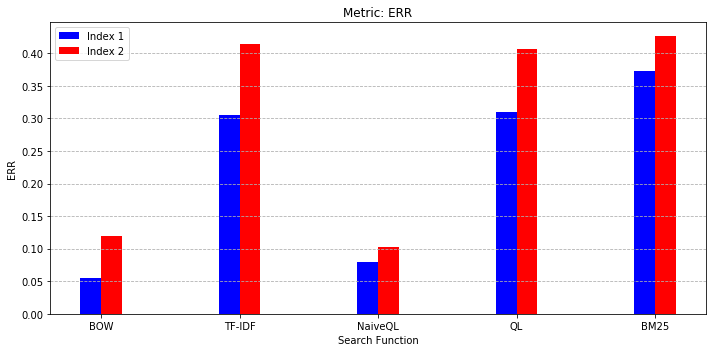

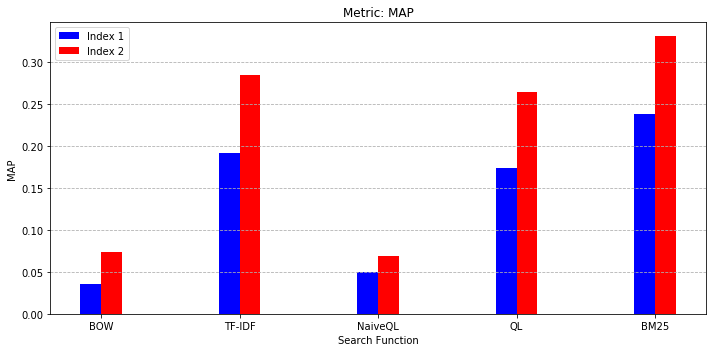

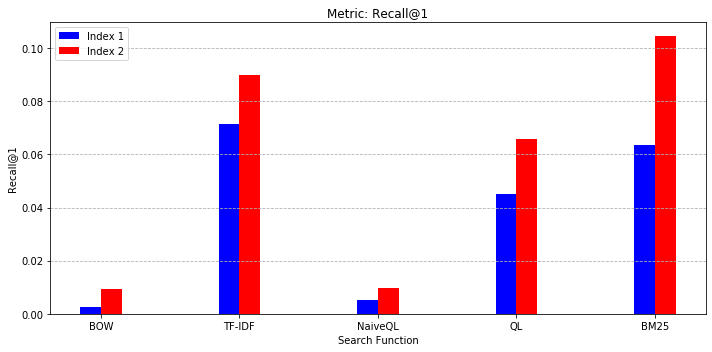

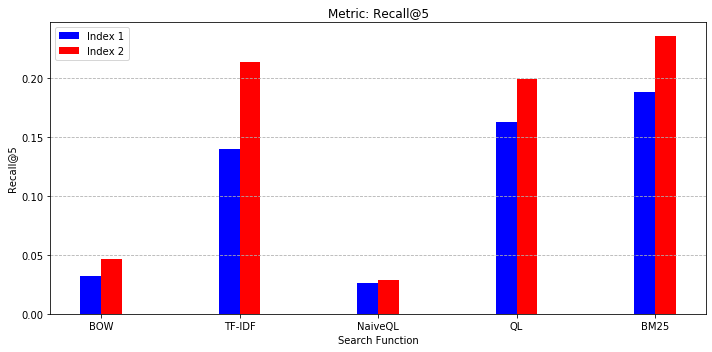

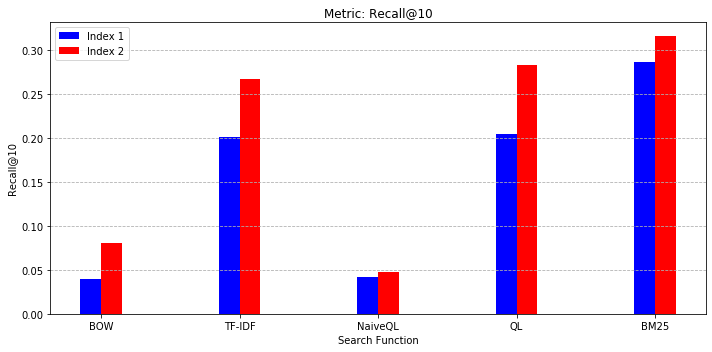

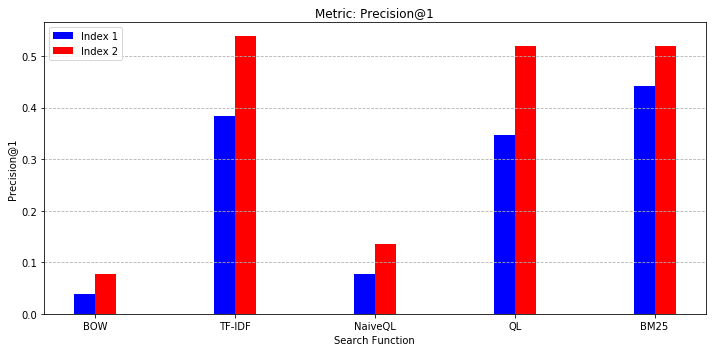

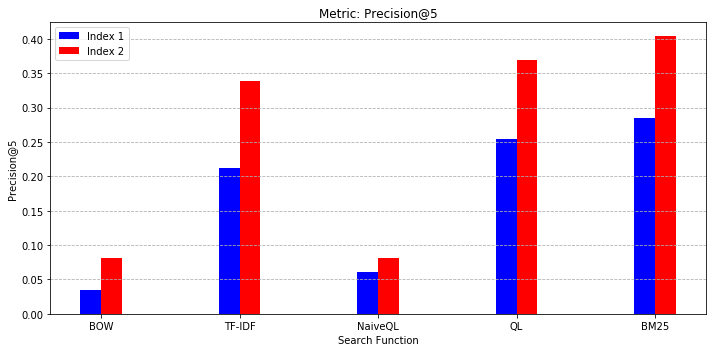

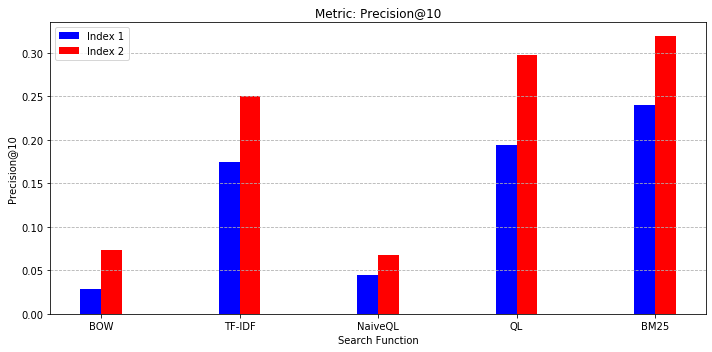

In [70]:
# YOUR CODE HERE
indices = [1,2]
data_index_1, data_index_2 = [], []
for method, method_fn in list_of_search_fns:
    for index in indices:
        dictionary = evaluate_search_fn(method_fn, list_of_metrics, index)
        #print(f'method : {method}' " " 'with' " " f'index : {index}', dictionary)
        #print('================================================================')
        values = list(dictionary.values())
        if index == 1:
            data_index_1.append(values)
        else:
            data_index_2.append(values)
metrics = list(dictionary.keys())
X = np.arange(len(list_of_search_fns))
bar_width = 0.15

#plot result for each metric
for i, metric in enumerate(metrics):
    fig = plt.figure(figsize=(10,5))
    index_plots = defaultdict(list)
    for search_function in list_of_search_fns:
        index_plots[0].append(plt.bar(X + i * bar_width, [method[i] for method in data_index_1], bar_width, label="Index 1", color='b'))
        index_plots[1].append(plt.bar(X + i * bar_width + bar_width, [method[i] for method in data_index_2], bar_width, label= "Index 2", color='r'))
    plt.xticks(X + i * bar_width + bar_width/2 , [method[0] for method in list_of_search_fns])
    plt.legend([tuple(index_plots[0]), tuple(index_plots[1])], ["Index 1", "Index 2"])
    plt.title(f'Metric: {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('Search Function')
    plt.grid(axis = 'y', linestyle = '--')
    fig.tight_layout()
    plt.show()

---
### Section 5.2: Summary (10 points)
Write a summary of what you observe in the results.
Your summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.      

The first conclusion to be drawn is that the results for the second index are always better than the ones for the first index. This was expected since the configuration used for the second index includes stemming, stopwords removal, and lowercasing as opposed to the first configuration, which only contains lowercasing. Accordingly, since the processing pipeline is more advanced for the second index, it allows the tokens of the index to match better with the ones of the query. Hence, the results are also better. 

Secondly, one can observe each plot looks similar in terms of the ranking of the search functions and the relative difference between their scores. Generally, every graph displays BM25 achieving the best scores, followed closely by TF-IDF and QL. Then, BOW and NaiveQL have comparable results but significantly lower. 

Next, it comes as no surprise that QL performs better than Naive QL as the main purpose of the first method is to include smoothing to solve the naive method's problem, namely dealing with vocabulary terms that do not appear in a document. Moreover, one could expect BM25 to outperform the other algorithms because it is the most complex method, combining the strengths of TF-IDF and QL_search. When it comes to BOW, its weak scores are anticipated since it is relatively basic compared to the other ones. Finally, although Naive QL deals with long documents by dividing their length, it has a major drawback when vocabulary terms do not appear in documents. Hence, it was expected to perform poorly. 

Nevertheless, there are a couple of exceptions to the previously described pattern. For the recall at rank 1, TF-IDF achieves the best score for index 1. Additionally, assessing the Precision at rank 1, one can see TF-IDF scores slightly better than BM25 and QL for index 2. One possible explanation is that TF-IDF scores best by chance as the variability of the results gets larger when the rank of the metric goes lower. More precisely, precision at rank 1 has a larger confidence interval than precision at rank 5. As a confirmation, the methods converge to the ranking described in the first paragraph (i.e. BM25 > QL ~ TF-IDF >> Naive QL ~ BOW) as the rank of the metric increases.

---
---
# Part 2: Semantic-based Matching (85 points) <a class="anchor" id="part2"></a>

[Back to top](#top)

We will now experiment with methods that go beyond lexical methods like TF-IDF, which operate at the word level and are high dimensional and sparse, and look at methods which constructs low dimensional dense representations of queries and documents. 

Since these low-dimensional methods have a higher time complexity, they are typically used in conjunction with methods like BM-25. That is, instead of searching through potentially million documents to find matches using low dimensional vectors, a list of K documents are retrieved using BM25, and then **re-ranked** using the other method. This is the method that is going to be applied in the following exercises. 

LSI/LDA takes documents that are similar on a semantic level - for instance, if they are describing the same topic - and projects them into nearby vectors, despite having low lexical overlap.

In this assignment, you will use `gensim` to create LSI/LDA models and use them in re-ranking. 

**Note**: The following exercises only uses `doc_repr_2` and `config_2`

Table of contents:
- [Section 6: LSI](#lsi) (15 points)
- [Section 7: LDA](#lda) (10 points)
- [Section 8: Word2Vec/Doc2Vec](#2vec) (20 points)
- [Section 8: Re-ranking](#reranking) (10 points)
- [Section 9: Re-ranking Evaluation](#reranking_eval) (30 points)

---
## Section 6: Latent Semantic Indexing (LSI) (15 points) <a class="anchor" id="lsi"></a>

[Back to Part 2](#part2)

LSI is one of the methods to embed the queries and documents into vectors. It is based on a method similar to Principal Component Analysis (PCA) for obtaining a dense concept matrix out of the sparse term-document matrix.

See [wikipedia](https://en.wikipedia.org/wiki/Latent_semantic_analysis), particularly [#Mathematics_of_LSI](https://en.wikipedia.org/wiki/Latent_semantic_analysis#Mathematics_of_LSI).

In [71]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LsiModel, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import downloader as g_downloader
# gensim uses logging, so set it up 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

---
### Section 6.1: Cosine Similarity (5 points)<a class="anchor" id="cosing_sim"></a>
Before we begin, let us first define our method of similarity for the LSI model, the cosine similarity:

$$\text{similarity} = \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$

Since we are using gensim, the types of vectors returned by their classes are of the form defined below (they are not just simple vectors):

In [72]:
# 1, 2, 3 are either latent dimensions (LSI), or topics (LDA)
# The second value in each tuple is a number (LSI) or a probability (LDA)  
example_vec_1 = [(1, 0.2), (2, 0.3), (3, 0.4)]
example_vec_2 = [(1, 0.2), (2, 0.7), (3, 0.4)]

---
**Implementation (2+3 points):**
Now, implement the `dot product` operation on these types of vectors and using this operator, implement the `cosine similarity` (don't forget: two functions to implement!):

In [73]:
# TODO: Implement this! (2 points)
def dot(vec_1,vec_2): 
    """
        vec_1 and vec_2 are of the form: [(int, float), (int, float), ...]
        Return the dot product of two such vectors, computed only on the floats
        You can assume that the lengths of the vectors are the same, and the dimensions are aligned 
            i.e you won't get: vec_1 = [(1, 0.2)] ; vec_2 = [(2, 0.3)] 
                                (dimensions are unaligned and lengths are different)
    """
    # YOUR CODE HERE
    vec_1 = np.array([b for (a,b) in vec_1])
    vec_2 = np.array([b for (a,b) in vec_2])
    if vec_1.shape != vec_2.shape:
        return 0
    return np.dot(vec_1, vec_2)



# TODO: Implement this! (3 points)
def cosine_sim(vec_1, vec_2):
    # YOUR CODE HERE
    return dot(vec_1, vec_2) / (np.linalg.norm(np.array([b for (a,b) in vec_1])) * np.linalg.norm(np.array([b for (a,b) in vec_2])))

In [74]:
##### Function check
print(f'vectors: {(example_vec_1,example_vec_2)}')
print(f'dot product = {dot(example_vec_1,example_vec_2)}')
print(f'cosine similarity = {cosine_sim(example_vec_1,example_vec_2)}')
##### 

vectors: ([(1, 0.2), (2, 0.3), (3, 0.4)], [(1, 0.2), (2, 0.7), (3, 0.4)])
dot product = 0.41000000000000003
cosine similarity = 0.9165587597202866


In [75]:
#### Please do not change this. This cell is used for grading.

---
### Section 6.2: LSI Retrieval (10 points)<a class="anchor" id="lsi_retrieval"></a>
LSI retrieval is simply ranking the documents based on their cosine similarity to the query vector.
First, let's write a parent class for vector-based retrieval models:

In [76]:
class VectorSpaceRetrievalModel:
    """
        Parent class for Dense Vector Retrieval models
    """
    def __init__(self, doc_repr):
        """
            document_collection: 
                [
                    (doc_id_1, [token 1, token 2, ...]), 
                    (doc_id_2, [token 1, token 2, ....]) 
                    ...
                ]

        """
        self.doc_repr = doc_repr
        self.documents = [_[1] for _ in self.doc_repr]
        
        # construct a dictionary
        self.dictionary = Dictionary(self.documents)
        # Filter out words that occur less than 20 documents, or more than 50% of the documents.
        self.dictionary.filter_extremes(no_below=10)
        self.corpus = [self.dictionary.doc2bow(doc) for doc in self.documents]
    
        # Make a index to word dictionary.
        temp = self.dictionary[0]  # This is only to "load" the dictionary.
        self.id2word = self.dictionary.id2token
        
        # this is set by the train_model function
        self.model = None
        
        
    def vectorize_documents(self):
        """
            Returns a doc_id -> vector dictionary
        """
        vectors = {}
        for (doc_id, _), cc in zip(self.doc_repr, self.corpus):
            vectors[doc_id] = self.model[cc]
        return vectors

    def vectorize_query(self, query):
        # Note the use of config_2 here!
        query = process_text(query, **config_2)
        query_vector = self.dictionary.doc2bow(query)
        return self.model[query_vector]
    
    def train_model(self):
        """
            Trains a model and sets the 'self.model' variable. 
            Make sure to use the variables created in the __init__ method.
            e.g the variables which may be useful: {corpus, dictionary, id2word}
        """
        raise NotImplementedError()

---
**Implementation (5 points):**
Implement the `train_model` method in the following class (note that this is only one line of code in `gensim`!). Ensure that the parameters defined in the `__init__` method are not changed, and are *used in the `train_method` function*. Normally, the hyperaparameter space will be searched using grid search / other methods - in this assignment we have provided the hyperparameters for you.

The last two lines of code train an LSI model on the list of documents which have been stemmed, lower-cased and have stopwords removed. 

In [77]:
# TODO: Implement this! (5 points)
class LsiRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        self.num_topics = 100
        self.chunksize = 2000
    
    def train_model(self):
        # YOUR CODE HERE
        self.model = LsiModel(corpus=self.corpus, num_topics=self.num_topics, id2word=self.id2word, chunksize=self.chunksize)

In [78]:
##### Function check
lsi = LsiRetrievalModel(doc_repr_2)
lsi.train_model()

# you can now get an LSI vector for a given query in the following way:
lsi.vectorize_query("report")
##### 

2022-02-28 23:03:12,429 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-28 23:03:12,534 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)
2022-02-28 23:03:12,540 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2022-02-28 23:03:12,541 : INFO : keeping 1197 tokens which were in no less than 10 and no more than 1602 (=50.0%) documents
2022-02-28 23:03:12,543 : INFO : resulting dictionary: Dictionary(1197 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...)
2022-02-28 23:03:12,602 : INFO : using serial LSI version on this node
2022-02-28 23:03:12,602 : INFO : updating model with new documents
2022-02-28 23:03:12,603 : INFO : preparing a new chunk of documents
2022-02-28 23:03:12,613 : INFO : using 100 extra sam

[(0, 0.015212486859184606),
 (1, -0.016262238128742033),
 (2, -0.00023439864394768188),
 (3, -0.0018147772687144136),
 (4, -0.009435277422037836),
 (5, -0.004662695377306764),
 (6, 0.027020407501979544),
 (7, 0.01663983586081748),
 (8, -0.03180722880869896),
 (9, -0.0006258822552084528),
 (10, 0.00216008364768362),
 (11, -0.017234355296542936),
 (12, 0.0002545918645605865),
 (13, 0.001144884438797158),
 (14, 0.003914651274200232),
 (15, 0.005211693009748445),
 (16, 0.006216366210270374),
 (17, 0.002981955273892615),
 (18, -0.017789465326986824),
 (19, 0.020032436274524588),
 (20, -0.0096621398790371),
 (21, -0.014441573128452683),
 (22, 0.04725183851176938),
 (23, 0.02675583200434143),
 (24, -0.007618660304917299),
 (25, -0.013370034254597108),
 (26, 0.005447461843797435),
 (27, 0.07828990215403583),
 (28, -0.057340285672019986),
 (29, 0.031314510917822634),
 (30, 0.04007633528868333),
 (31, 0.04525726899827779),
 (32, -0.07187795883232617),
 (33, 0.049500246375482435),
 (34, -0.023502

\#### Please do not change this. This cell is used for grading.

---
**Implementation (5 points):**
 Next, implement a basic ranking class for vector space retrieval (used for all semantic methods): 

In [79]:
# TODO: Implement this! (5 points)
class DenseRetrievalRanker:
    def __init__(self, vsrm, similarity_fn):
        """
            vsrm: instance of `VectorSpaceRetrievalModel`
            similarity_fn: function instance that takes in two vectors 
                            and returns a similarity score e.g cosine_sim defined earlier
        """
        self.vsrm = vsrm 
        self.vectorized_documents = self.vsrm.vectorize_documents()
        self.similarity_fn = similarity_fn
    
    def _compute_sim(self, query_vector):
        """
            Compute the similarity of `query_vector` to documents in 
            `self.vectorized_documents` using `self.similarity_fn`
            Returns a list of (doc_id, score) tuples
        """
        # YOUR CODE HERE
        return [(key ,self.similarity_fn(query_vector, value)) for key, value in self.vectorized_documents.items()]
    
    def search(self, query):
        scores = self._compute_sim(self.vsrm.vectorize_query(query))
        scores.sort(key=lambda _:-_[1])
        return scores 

In [80]:
##### Function check
drm_lsi = DenseRetrievalRanker(lsi, cosine_sim)
drm_lsi.search("report")[:5]
##### 

/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


[('599', 0.793250830259822),
 ('53', 0.5101123089856474),
 ('1339', 0.44416690063137393),
 ('3160', 0.43936206401879224),
 ('196', 0.4163167845014836)]

\#### Please do not change this. This cell is used for grading.

---
Now, you can test your LSI model in the following cell: try finding queries which are lexically different to documents, but semantically similar - does LSI work well for these queries?!

In [81]:
# test your LSI model
search_fn = drm_lsi.search

text = widgets.Text(description="Search Bar", width=200)
display(text)

def make_results_2(query, search_fn):
    results = []
    for doc_id, score in search_fn(query):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results

def handle_submit_2(sender):
    print(f"Searching for: '{sender.value}' (SEARCH FN: {search_fn})")
    
    results = make_results_2(sender.value, search_fn)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

---
## Section 7: Latent Dirichlet Allocation (LDA) (10 points) <a class="anchor" id="lda"></a>

[Back to Part 2](#part2)

The specifics of LDA is out of the scope of this assignment, but we will use the `gensim` implementation to perform search using LDA over our small document collection. The key thing to remember is that LDA, unlike LSI, outputs a topic **distribution**, not a vector. With that in mind, let's first define a similarity measure.


---
### Section 7.1: Jenson-Shannon divergence (5 points) <a class="anchor" id="js_sim"></a>

The Jenson-Shannon divergence is a symmetric and finite measure on two probability distributions (unlike the KL, which is neither). For identical distributions, the JSD is equal to 0, and since our code uses 0 as irrelevant and higher scores as relevant, we use `(1 - JSD)` as the score or 'similarity' in our setup

**Note**: the JSD is bounded to \[0,1\] only if we use log base 2. So please ensure that you're using `np.log2` instead of `np.log`

In [82]:
## TODO: Implement this! (5 points)

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log2(p / q), 0))

def jenson_shannon_divergence(vec_1, vec_2, assert_prob=False):
    """
        Computes the Jensen-Shannon divergence between two probability distributions. 
        NOTE: DO NOT RETURN 1 - JSD here, that is handled by the next function which is already implemented! 
        The inputs are *gensim* vectors - same as the vectors for the cosine_sim function
        assert_prob is a flag that checks if the inputs are proper probability distributions 
            i.e they sum to 1 and are positive - use this to check your inputs if needed. 
                (This is optional to implement, but recommended - 
                you can the default to False to save a few ms off the runtime)
    """
    # YOUR CODE HERE
    P = np.array([b for (a,b) in vec_1])
    Q = np.array([b for (a,b) in vec_2])
    if assert_prob:
        assert((P > 0).all() and (Q > 0).all())
        assert(np.sum(P) == 1.0 and np.sum(Q) == 1.0)
    M = 0.5 * (P + Q)
    return 0.5 * (kl_divergence(P, M) + kl_divergence(Q, M))

def jenson_shannon_sim(vec_1, vec_2, assert_prob=False):
    return 1 - jenson_shannon_divergence(vec_1, vec_2)



In [83]:
##### Function check
vec_1 = [(1, 0.3), (2, 0.4), (3, 0.3)]
vec_2 = [(1, 0.1), (2, 0.7), (3, 0.2)]
jenson_shannon_sim(vec_1, vec_2, assert_prob=True)
##### 

0.9251064410358459

---
### Section 7.2: LDA retrieval (5 points) <a class="anchor" id="lda_ret"></a>

Implement the `train_model` method in the following class (note that this is only one line of code in `gensim`!). Ensure that the parameters defined in the `__init__` method are not changed, and are *used in the `train_method` function*. You do not need to set this. Normally, the hyperaparameter space will be searched using grid search / other methods. Note that training the LDA model might take some time

The last two lines of code train an LDA model on the list of documents which have been stemmed, lower-cased and have stopwords removed. 

In [84]:
# TODO: Implement this! (5 points)
class LdaRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        # use these parameters in the train_model method
        self.num_topics = 100
        self.chunksize = 2000
        self.passes = 20
        self.iterations = 400
        self.eval_every = 10
        # this is need to get full vectors
        self.minimum_probability=0.0
        self.alpha='auto'
        self.eta='auto'
    
    
    def train_model(self):
        # YOUR CODE HERE
        self.model = LdaModel(corpus = self.corpus, num_topics=self.num_topics, chunksize=self.chunksize, passes=self.passes, iterations=self.iterations, eval_every=self.eval_every,\
                                minimum_probability=self.minimum_probability, alpha=self.alpha, eta=self.eta)

In [85]:
##### Function check
lda = LdaRetrievalModel(doc_repr_2)
lda.train_model()

# you can now get an LDA vector for a given query in the following way:
lda.vectorize_query("report")
##### 

2022-02-28 23:03:14,556 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-28 23:03:14,665 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)
2022-02-28 23:03:14,671 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2022-02-28 23:03:14,672 : INFO : keeping 1197 tokens which were in no less than 10 and no more than 1602 (=50.0%) documents
2022-02-28 23:03:14,674 : INFO : resulting dictionary: Dictionary(1197 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...)
2022-02-28 23:03:14,751 : WARNING : no word id mapping provided; initializing from corpus, assuming identity
2022-02-28 23:03:14,758 : INFO : using autotuned alpha, starting with [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 

2022-02-28 23:03:22,757 : INFO : merging changes from 2000 documents into a model of 3204 documents
2022-02-28 23:03:22,770 : INFO : topic #39 (0.010): 0.069*"0" + 0.043*"115" + 0.038*"668" + 0.035*"128" + 0.034*"154" + 0.029*"315" + 0.024*"520" + 0.024*"50" + 0.024*"1098" + 0.022*"392"
2022-02-28 23:03:22,771 : INFO : topic #47 (0.010): 0.174*"398" + 0.065*"458" + 0.055*"83" + 0.046*"50" + 0.036*"34" + 0.036*"667" + 0.034*"117" + 0.029*"0" + 0.027*"1017" + 0.024*"35"
2022-02-28 23:03:22,771 : INFO : topic #99 (0.010): 0.055*"50" + 0.030*"843" + 0.024*"146" + 0.022*"174" + 0.020*"20" + 0.020*"13" + 0.017*"320" + 0.016*"390" + 0.015*"242" + 0.014*"15"
2022-02-28 23:03:22,772 : INFO : topic #41 (0.011): 0.178*"34" + 0.153*"83" + 0.140*"35" + 0.045*"19" + 0.036*"254" + 0.033*"12" + 0.033*"611" + 0.028*"631" + 0.026*"222" + 0.024*"73"
2022-02-28 23:03:22,773 : INFO : topic #71 (0.011): 0.174*"34" + 0.159*"35" + 0.123*"83" + 0.045*"859" + 0.029*"50" + 0.025*"273" + 0.024*"611" + 0.022*"54" 

2022-02-28 23:03:33,458 : INFO : topic #87 (0.011): 0.068*"83" + 0.061*"1083" + 0.059*"50" + 0.046*"79" + 0.036*"146" + 0.034*"1183" + 0.033*"24" + 0.028*"1162" + 0.027*"36" + 0.027*"34"
2022-02-28 23:03:33,459 : INFO : topic #71 (0.012): 0.189*"34" + 0.171*"35" + 0.115*"83" + 0.079*"859" + 0.054*"611" + 0.037*"36" + 0.025*"24" + 0.020*"54" + 0.020*"454" + 0.019*"273"
2022-02-28 23:03:33,460 : INFO : topic #96 (0.012): 0.332*"34" + 0.309*"35" + 0.221*"83" + 0.043*"69" + 0.027*"0" + 0.011*"536" + 0.009*"386" + 0.008*"1154" + 0.006*"254" + 0.006*"485"
2022-02-28 23:03:33,462 : INFO : topic diff=0.482941, rho=0.466151
2022-02-28 23:03:33,475 : INFO : PROGRESS: pass 3, at document #2000/3204
2022-02-28 23:03:35,628 : INFO : optimized alpha [0.010070867, 0.01050829, 0.009880945, 0.009805658, 0.009812961, 0.010297127, 0.00986403, 0.010151123, 0.010901843, 0.01082012, 0.009808332, 0.010676395, 0.010006198, 0.010256572, 0.009865235, 0.010092747, 0.010186406, 0.010807228, 0.009841551, 0.0105206

2022-02-28 23:03:42,229 : INFO : topic diff=0.594102, rho=0.389191
2022-02-28 23:03:44,525 : INFO : -6.646 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 1204 documents with 49783 words
2022-02-28 23:03:44,526 : INFO : PROGRESS: pass 4, at document #3204/3204
2022-02-28 23:03:46,415 : INFO : optimized alpha [0.010586378, 0.010873814, 0.00997067, 0.010012355, 0.009862353, 0.010667356, 0.010016925, 0.010367542, 0.011537565, 0.01110052, 0.009815601, 0.011301338, 0.0103186, 0.010621695, 0.010079709, 0.01042559, 0.010441423, 0.011479973, 0.009909917, 0.010915633, 0.010351131, 0.010334524, 0.0096928, 0.011405058, 0.010288405, 0.010674454, 0.010484299, 0.010163348, 0.010432242, 0.010647171, 0.010737367, 0.01009523, 0.010291566, 0.011625494, 0.009824573, 0.01105625, 0.011151072, 0.0107190525, 0.012071367, 0.010026603, 0.01085234, 0.011840226, 0.010789441, 0.010790248, 0.010553856, 0.010979663, 0.010109284, 0.010147249, 0.010840323, 0.009726021, 0.011267426, 0.010337126

2022-02-28 23:03:54,941 : INFO : merging changes from 2000 documents into a model of 3204 documents
2022-02-28 23:03:54,955 : INFO : topic #22 (0.010): 0.065*"722" + 0.060*"999" + 0.058*"131" + 0.054*"83" + 0.045*"995" + 0.040*"50" + 0.031*"791" + 0.031*"0" + 0.025*"401" + 0.025*"871"
2022-02-28 23:03:54,956 : INFO : topic #49 (0.010): 0.172*"652" + 0.086*"1068" + 0.065*"469" + 0.051*"6" + 0.034*"50" + 0.029*"844" + 0.028*"427" + 0.025*"850" + 0.025*"73" + 0.023*"15"
2022-02-28 23:03:54,957 : INFO : topic #60 (0.013): 0.581*"176" + 0.232*"429" + 0.032*"57" + 0.026*"799" + 0.021*"15" + 0.015*"185" + 0.011*"41" + 0.011*"425" + 0.011*"128" + 0.010*"635"
2022-02-28 23:03:54,959 : INFO : topic #71 (0.014): 0.203*"34" + 0.175*"35" + 0.092*"83" + 0.071*"36" + 0.067*"859" + 0.063*"611" + 0.049*"24" + 0.029*"526" + 0.021*"296" + 0.020*"40"
2022-02-28 23:03:54,960 : INFO : topic #96 (0.020): 0.365*"34" + 0.336*"35" + 0.206*"83" + 0.031*"69" + 0.017*"0" + 0.009*"536" + 0.008*"254" + 0.006*"1154" 

2022-02-28 23:04:05,488 : INFO : topic #60 (0.014): 0.591*"176" + 0.255*"429" + 0.030*"799" + 0.027*"57" + 0.019*"15" + 0.015*"185" + 0.010*"635" + 0.009*"41" + 0.008*"425" + 0.008*"48"
2022-02-28 23:04:05,489 : INFO : topic #71 (0.015): 0.204*"34" + 0.179*"35" + 0.092*"83" + 0.080*"859" + 0.075*"36" + 0.075*"611" + 0.050*"24" + 0.032*"526" + 0.021*"40" + 0.015*"296"
2022-02-28 23:04:05,489 : INFO : topic #96 (0.024): 0.381*"34" + 0.344*"35" + 0.190*"83" + 0.030*"69" + 0.017*"0" + 0.008*"536" + 0.007*"254" + 0.005*"1154" + 0.004*"485" + 0.004*"78"
2022-02-28 23:04:05,490 : INFO : topic diff=0.505056, rho=0.322715
2022-02-28 23:04:05,503 : INFO : PROGRESS: pass 8, at document #2000/3204
2022-02-28 23:04:07,455 : INFO : optimized alpha [0.012029356, 0.011532924, 0.010066616, 0.0104497485, 0.009924645, 0.011286765, 0.010393599, 0.010667511, 0.012558165, 0.011437451, 0.009867786, 0.012688092, 0.010913251, 0.011401876, 0.010388199, 0.01098042, 0.010761391, 0.012815787, 0.009964382, 0.011625

2022-02-28 23:04:13,187 : INFO : topic diff=0.383256, rho=0.293585
2022-02-28 23:04:15,252 : INFO : -6.506 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 1204 documents with 49783 words
2022-02-28 23:04:15,253 : INFO : PROGRESS: pass 9, at document #3204/3204
2022-02-28 23:04:17,174 : INFO : optimized alpha [0.012749207, 0.011942619, 0.010191008, 0.010742803, 0.010038786, 0.011642671, 0.010540566, 0.010947336, 0.013091914, 0.011681787, 0.00998918, 0.013306815, 0.01125761, 0.011752667, 0.010629935, 0.011290277, 0.010972639, 0.013582239, 0.010104544, 0.01200062, 0.011419969, 0.011063755, 0.0098794745, 0.0131735355, 0.010841023, 0.011402497, 0.01110885, 0.010671017, 0.011130506, 0.0115662385, 0.011997524, 0.011122885, 0.010967278, 0.01391776, 0.009944749, 0.01279919, 0.012336148, 0.011632064, 0.014277386, 0.011215093, 0.012231628, 0.013780906, 0.01161646, 0.012292346, 0.01196482, 0.01265021, 0.01072914, 0.010886313, 0.011387195, 0.009985822, 0.012549174, 0.01132343

2022-02-28 23:04:24,483 : INFO : merging changes from 2000 documents into a model of 3204 documents
2022-02-28 23:04:24,497 : INFO : topic #22 (0.010): 0.078*"999" + 0.071*"722" + 0.071*"131" + 0.050*"995" + 0.044*"83" + 0.037*"50" + 0.035*"791" + 0.030*"117" + 0.027*"871" + 0.026*"401"
2022-02-28 23:04:24,498 : INFO : topic #34 (0.010): 0.146*"41" + 0.104*"1185" + 0.065*"50" + 0.055*"91" + 0.052*"1147" + 0.049*"269" + 0.035*"1184" + 0.031*"243" + 0.027*"6" + 0.026*"660"
2022-02-28 23:04:24,499 : INFO : topic #60 (0.016): 0.638*"176" + 0.226*"429" + 0.029*"57" + 0.026*"799" + 0.017*"15" + 0.015*"185" + 0.011*"635" + 0.007*"41" + 0.007*"48" + 0.006*"425"
2022-02-28 23:04:24,500 : INFO : topic #71 (0.017): 0.206*"34" + 0.179*"35" + 0.091*"36" + 0.086*"83" + 0.069*"859" + 0.068*"611" + 0.064*"24" + 0.038*"526" + 0.020*"40" + 0.016*"379"
2022-02-28 23:04:24,501 : INFO : topic #96 (0.034): 0.389*"34" + 0.349*"35" + 0.186*"83" + 0.029*"69" + 0.015*"0" + 0.008*"536" + 0.005*"1154" + 0.004*"48

2022-02-28 23:04:33,309 : INFO : topic #60 (0.017): 0.625*"176" + 0.245*"429" + 0.029*"799" + 0.027*"57" + 0.016*"15" + 0.015*"185" + 0.010*"635" + 0.007*"48" + 0.006*"41" + 0.005*"425"
2022-02-28 23:04:33,310 : INFO : topic #71 (0.018): 0.205*"34" + 0.181*"35" + 0.090*"36" + 0.088*"83" + 0.079*"859" + 0.076*"611" + 0.061*"24" + 0.040*"526" + 0.018*"40" + 0.015*"486"
2022-02-28 23:04:33,312 : INFO : topic #96 (0.039): 0.400*"34" + 0.351*"35" + 0.177*"83" + 0.029*"69" + 0.015*"0" + 0.008*"536" + 0.005*"1154" + 0.004*"485" + 0.003*"78" + 0.003*"821"
2022-02-28 23:04:33,313 : INFO : topic diff=0.268945, rho=0.261694
2022-02-28 23:04:33,324 : INFO : PROGRESS: pass 13, at document #2000/3204
2022-02-28 23:04:35,002 : INFO : optimized alpha [0.014466733, 0.012617475, 0.010339068, 0.0113903815, 0.010245772, 0.012216773, 0.010861162, 0.011477421, 0.014012728, 0.012036375, 0.01023434, 0.01454279, 0.011851436, 0.012506734, 0.011056462, 0.011828903, 0.011284183, 0.015022443, 0.010363095, 0.012690

2022-02-28 23:04:40,429 : INFO : topic diff=0.214160, rho=0.245426
2022-02-28 23:04:42,272 : INFO : -6.450 per-word bound, 87.4 perplexity estimate based on a held-out corpus of 1204 documents with 49783 words
2022-02-28 23:04:42,273 : INFO : PROGRESS: pass 14, at document #3204/3204
2022-02-28 23:04:43,836 : INFO : optimized alpha [0.015233468, 0.0129983835, 0.010482029, 0.011785828, 0.010386031, 0.012531985, 0.0110101495, 0.011824965, 0.014527785, 0.012265114, 0.010407705, 0.015107326, 0.012169096, 0.012840837, 0.011343878, 0.012134262, 0.011477585, 0.015852235, 0.010588808, 0.013049131, 0.012367612, 0.011842442, 0.010109339, 0.014871124, 0.011307639, 0.012082681, 0.011773519, 0.011651973, 0.011840704, 0.012433162, 0.013211419, 0.012260044, 0.01169698, 0.01614002, 0.010217674, 0.014528347, 0.013321166, 0.012522841, 0.016388396, 0.012415581, 0.013346612, 0.01557555, 0.012471985, 0.013855711, 0.013549344, 0.014303967, 0.0114745125, 0.011518026, 0.011943885, 0.01039293, 0.013852726, 0.0

2022-02-28 23:04:50,182 : INFO : merging changes from 2000 documents into a model of 3204 documents
2022-02-28 23:04:50,194 : INFO : topic #22 (0.010): 0.083*"999" + 0.079*"131" + 0.075*"722" + 0.054*"995" + 0.040*"791" + 0.034*"117" + 0.033*"50" + 0.032*"83" + 0.029*"871" + 0.028*"401"
2022-02-28 23:04:50,195 : INFO : topic #34 (0.010): 0.156*"41" + 0.099*"1185" + 0.071*"50" + 0.053*"91" + 0.050*"1147" + 0.047*"269" + 0.034*"1184" + 0.031*"243" + 0.030*"660" + 0.025*"6"
2022-02-28 23:04:50,196 : INFO : topic #60 (0.019): 0.648*"176" + 0.226*"429" + 0.029*"57" + 0.027*"799" + 0.016*"15" + 0.015*"185" + 0.011*"635" + 0.007*"48" + 0.006*"41" + 0.002*"425"
2022-02-28 23:04:50,197 : INFO : topic #71 (0.019): 0.208*"34" + 0.181*"35" + 0.100*"36" + 0.082*"83" + 0.072*"859" + 0.071*"611" + 0.070*"24" + 0.044*"526" + 0.018*"486" + 0.016*"379"
2022-02-28 23:04:50,198 : INFO : topic #96 (0.051): 0.399*"34" + 0.351*"35" + 0.181*"83" + 0.028*"69" + 0.013*"0" + 0.009*"536" + 0.005*"1154" + 0.003*"4

2022-02-28 23:04:57,251 : INFO : topic #60 (0.020): 0.634*"176" + 0.242*"429" + 0.030*"799" + 0.028*"57" + 0.015*"15" + 0.015*"185" + 0.010*"635" + 0.007*"48" + 0.006*"41" + 0.002*"425"
2022-02-28 23:04:57,251 : INFO : topic #71 (0.020): 0.209*"34" + 0.182*"35" + 0.098*"36" + 0.085*"83" + 0.081*"859" + 0.078*"611" + 0.066*"24" + 0.044*"526" + 0.018*"486" + 0.015*"401"
2022-02-28 23:04:57,252 : INFO : topic #96 (0.056): 0.408*"34" + 0.352*"35" + 0.173*"83" + 0.028*"69" + 0.013*"0" + 0.008*"536" + 0.005*"1154" + 0.003*"485" + 0.003*"78" + 0.003*"821"
2022-02-28 23:04:57,253 : INFO : topic diff=0.174765, rho=0.225865
2022-02-28 23:04:57,264 : INFO : PROGRESS: pass 18, at document #2000/3204
2022-02-28 23:04:58,565 : INFO : optimized alpha [0.017054018, 0.013653588, 0.010669839, 0.012580368, 0.010648013, 0.013059813, 0.011328746, 0.012432615, 0.015389206, 0.0126264775, 0.01069858, 0.016266719, 0.012750486, 0.013547787, 0.011846176, 0.012635471, 0.011794354, 0.017427508, 0.010954948, 0.0137

2022-02-28 23:05:02,656 : INFO : topic diff=0.149462, rho=0.215156
2022-02-28 23:05:04,076 : INFO : -6.418 per-word bound, 85.5 perplexity estimate based on a held-out corpus of 1204 documents with 49783 words
2022-02-28 23:05:04,077 : INFO : PROGRESS: pass 19, at document #3204/3204
2022-02-28 23:05:05,200 : INFO : optimized alpha [0.017845884, 0.014039641, 0.010820283, 0.013079123, 0.010814316, 0.013348537, 0.011466492, 0.012799556, 0.015852632, 0.01285281, 0.010870652, 0.016797764, 0.0130538335, 0.01386402, 0.012153249, 0.0129224155, 0.011980046, 0.01836582, 0.011193725, 0.014040595, 0.01323349, 0.012597736, 0.010396163, 0.016435154, 0.011830791, 0.012686616, 0.0123907635, 0.013076974, 0.01256705, 0.013264, 0.014480872, 0.013410047, 0.012424485, 0.01844892, 0.010552478, 0.016180508, 0.014151519, 0.013468235, 0.018299961, 0.013502069, 0.01435198, 0.0173996, 0.013307349, 0.015498177, 0.015182436, 0.016006177, 0.01225013, 0.012089188, 0.0124709485, 0.010791708, 0.015168388, 0.013000911

[(0, 0.0073167365),
 (1, 0.0057561933),
 (2, 0.00443627),
 (3, 0.0053623845),
 (4, 0.0044338233),
 (5, 0.005472843),
 (6, 0.004701213),
 (7, 0.005247764),
 (8, 0.0064995117),
 (9, 0.0052695973),
 (10, 0.004456921),
 (11, 0.0068870117),
 (12, 0.005352016),
 (13, 0.005684189),
 (14, 0.0049827807),
 (15, 0.0052981353),
 (16, 0.004911768),
 (17, 0.0075299083),
 (18, 0.0045893798),
 (19, 0.005756584),
 (20, 0.005425675),
 (21, 0.005165018),
 (22, 0.0042623826),
 (23, 0.0067383433),
 (24, 0.004850574),
 (25, 0.0052014585),
 (26, 0.00508016),
 (27, 0.005361504),
 (28, 0.005152437),
 (29, 0.005438184),
 (30, 0.0059370957),
 (31, 0.005498062),
 (32, 0.0050939857),
 (33, 0.007563979),
 (34, 0.004326471),
 (35, 0.006633939),
 (36, 0.005802063),
 (37, 0.005521919),
 (38, 0.0075029065),
 (39, 0.0055357907),
 (40, 0.0058842506),
 (41, 0.007133762),
 (42, 0.0054559563),
 (43, 0.0063541867),
 (44, 0.0062247342),
 (45, 0.0065624644),
 (46, 0.005022501),
 (47, 0.0049565155),
 (48, 0.005113036),
 (49, 0.

\#### Please do not change this. This cell is used for grading.

---
Now we can use the `DenseRetrievalModel` class to obtain an LDA search function.
You can test your LDA model in the following cell: Try finding queries which are lexically different to documents, but semantically similar - does LDA work well for these queries?!

In [86]:
drm_lda = DenseRetrievalRanker(lda, jenson_shannon_sim)

# test your LDA model
search_fn = drm_lda.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

## Section 8: Word2Vec/Doc2Vec (20 points) <a class="anchor" id="2vec"></a>

[Back to Part 2](#part2)

We will implement two other methods here, the Word2Vec model and the Doc2Vec model, also using `gensim`. Word2Vec creates representations of words, not documents, so the word level vectors need to be aggregated to obtain a representation for the document. Here, we will simply take the mean of the vectors. 


A drawback of these models is that they need a lot of training data. Our dataset is tiny, so in addition to using a model trained on the data, we will also use a pre-trained model for Word2Vec (this will be automatically downloaded).     

*Note*:
1. The code in vectorize_documents / vectorize_query should return gensim-like vectors i.e `[(dim, val), .. (dim, val)]`. 
2. For Word2Vec: You should also handle the following two cases: (a) A word in the query is not present in the vocabulary of the model and (b) none of the words in the query are present in the model - you can return 0 scores for all documents in this case. For either of these, you can check if a `word` is present in the vocab by using `word in self.model`


In [87]:
# TODO: Implement this! (10 points)
class W2VRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        # the dimensionality of the vectors
        self.size = 100 
        self.min_count = 1
    
    def train_model(self):
        """
        Trains the W2V model
        """
        # YOUR CODE HERE
        self.model = Word2Vec(self.documents, min_count=self.min_count, size=self.size)

    #Helper function
    def vectorize_list_of_words(self, words):
        query_vectors = np.empty((0,self.size))
        for word in words:
            if word in self.model.wv:
                query_vectors = np.vstack((query_vectors, self.model.wv[word][np.newaxis]))
            else:
                query_vectors = np.vstack((query_vectors, np.zeros(self.size)))
        if query_vectors.shape[0] == 0:
            return [(index, value) for index, value in enumerate(list(np.zeros(self.size)))]
        else:
            return [(index, value) for index, value in enumerate(list(np.mean(query_vectors, axis=0)))]
        
    def vectorize_documents(self):
        """
            Returns a doc_id -> vector dictionary
        """
        # YOUR CODE HERE
        vectors = {}
        for doc_id, words in self.doc_repr:
            vectors[doc_id] = self.vectorize_list_of_words(words)
        return vectors

    def vectorize_query(self, query):
        """
        Vectorizes the query using the W2V model
        """
        query = process_text(query, **config_2)
        # YOUR CODE HERE
        return self.vectorize_list_of_words(query)
    
    
class W2VPretrainedRetrievalModel(W2VRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        self.model_name = "word2vec-google-news-300"
        self.size = 300
    
    def train_model(self):
        """
        Loads the pretrained model
        """
        self.model = g_downloader.load(self.model_name)

w2v = W2VRetrievalModel(doc_repr_2)
w2v.train_model()

# you can now get a W2V vector for a given query in the following way:
w2v.vectorize_query("report")

2022-02-28 23:05:08,689 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-28 23:05:08,874 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)
2022-02-28 23:05:08,884 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2022-02-28 23:05:08,885 : INFO : keeping 1197 tokens which were in no less than 10 and no more than 1602 (=50.0%) documents
2022-02-28 23:05:08,890 : INFO : resulting dictionary: Dictionary(1197 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...)
2022-02-28 23:05:08,997 : INFO : collecting all words and their counts
2022-02-28 23:05:08,998 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-02-28 23:05:09,020 : INFO : collected 5937 word types from a corpus of 115969 raw w

[(0, -0.27290475368499756),
 (1, -0.11550870537757874),
 (2, 0.6499573588371277),
 (3, 0.9068551659584045),
 (4, 0.31919658184051514),
 (5, 0.511696994304657),
 (6, 0.2046755999326706),
 (7, 0.2332182228565216),
 (8, -0.3254537582397461),
 (9, 0.45841699838638306),
 (10, -0.2496698796749115),
 (11, 0.3438895344734192),
 (12, -0.8168692588806152),
 (13, -0.3142394721508026),
 (14, -0.27272266149520874),
 (15, 0.9138401746749878),
 (16, -0.10824038088321686),
 (17, -0.45273852348327637),
 (18, -0.10815726965665817),
 (19, -0.14284555613994598),
 (20, 0.4169790744781494),
 (21, 0.5140752196311951),
 (22, 0.04240879416465759),
 (23, -0.3616260290145874),
 (24, -0.24137626588344574),
 (25, -0.06417907774448395),
 (26, -0.6648340225219727),
 (27, 0.07901020348072052),
 (28, 0.3892073631286621),
 (29, 0.5607557892799377),
 (30, -0.20097191631793976),
 (31, -0.20225518941879272),
 (32, -0.046233151108026505),
 (33, 0.5174234509468079),
 (34, 0.4236476421356201),
 (35, 0.7059826850891113),
 (36

In [88]:
assert len(w2v.vectorize_query("report")) == 100
assert len(w2v.vectorize_query("this is a sentence that is not mellifluous")) == 100


\#### Please do not change this. This cell is used for grading.

In [89]:
w2v_pretrained = W2VPretrainedRetrievalModel(doc_repr_2)
w2v_pretrained.train_model()

# you can now get an W2V vector for a given query in the following way:
w2v_pretrained.vectorize_query("report")

2022-02-28 23:05:11,183 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-28 23:05:11,341 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)
2022-02-28 23:05:11,349 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2022-02-28 23:05:11,350 : INFO : keeping 1197 tokens which were in no less than 10 and no more than 1602 (=50.0%) documents
2022-02-28 23:05:11,353 : INFO : resulting dictionary: Dictionary(1197 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...)
2022-02-28 23:05:11,497 : INFO : loading projection weights from /home/sila/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
2022-02-28 23:06:06,631 : INFO : loaded (3000000, 300) matrix from /home/sila/gensim-data/word2vec-google-news-300/wo

[(0, -0.142578125),
 (1, -0.1640625),
 (2, -0.09033203125),
 (3, -0.1123046875),
 (4, 0.10009765625),
 (5, -0.041259765625),
 (6, 0.048828125),
 (7, -0.13671875),
 (8, 0.1962890625),
 (9, -0.134765625),
 (10, -0.017578125),
 (11, 0.0322265625),
 (12, 0.09521484375),
 (13, -0.10595703125),
 (14, -0.169921875),
 (15, 0.041015625),
 (16, -0.263671875),
 (17, -0.006317138671875),
 (18, -0.177734375),
 (19, -0.240234375),
 (20, 0.3515625),
 (21, -0.01220703125),
 (22, -0.162109375),
 (23, -0.12060546875),
 (24, 0.043212890625),
 (25, 0.10986328125),
 (26, 0.052490234375),
 (27, 0.1787109375),
 (28, -0.1455078125),
 (29, 0.1376953125),
 (30, -0.08203125),
 (31, -0.283203125),
 (32, -0.10888671875),
 (33, -0.2890625),
 (34, 0.072265625),
 (35, -0.04736328125),
 (36, 0.040283203125),
 (37, 0.06787109375),
 (38, 0.11669921875),
 (39, 0.00083160400390625),
 (40, 0.068359375),
 (41, 0.1201171875),
 (42, -0.08837890625),
 (43, 0.337890625),
 (44, -0.044677734375),
 (45, -0.0301513671875),
 (46, 0.

In [90]:
##### Function check

print(len(w2v_pretrained.vectorize_query("report")))
#####

300


/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [91]:
drm_w2v = DenseRetrievalRanker(w2v, cosine_sim)

# test your LDA model
search_fn = drm_w2v.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

In [92]:
drm_w2v_pretrained = DenseRetrievalRanker(w2v_pretrained, cosine_sim)

# test your LDA model
search_fn = drm_w2v_pretrained.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Text(value='', description='Search Bar')

**Implementation (10 points):**
For Doc2Vec, you will need to create a list of `TaggedDocument` instead of using the `self.corpus` or `self.documents` variable. Use the document id as the 'tag'.
  

In [93]:
# TODO: Implement this! (10 points)
class D2VRetrievalModel(VectorSpaceRetrievalModel):
    def __init__(self, doc_repr):
        super().__init__(doc_repr)
        
        self.vector_size= 100
        self.min_count = 1
        self.epochs = 20
        
        # YOUR CODE HERE
        self.tagged_documents = [TaggedDocument(words, [tag]) for tag, words in self.doc_repr]
        
    def train_model(self):
        # YOUR CODE HERE
        self.model = Doc2Vec(self.tagged_documents, min_count=self.min_count, vector_size=self.vector_size, epochs=self.epochs)
    
    def vectorize_documents(self):
        """
            Returns a doc_id -> vector dictionary
        """
        # YOUR CODE HERE
        vectors = {}
        for doc_id, words in self.doc_repr:
            vectors[doc_id] = [(index, value) for index, value in enumerate(list(self.model.infer_vector(words)))]
        return vectors

    def vectorize_query(self, query):
        # YOUR CODE HERE
        query = process_text(query, **config_2)
        return [(index, value) for index, value in enumerate(list(self.model.infer_vector(query)))]
        
d2v = D2VRetrievalModel(doc_repr_2)
d2v.train_model()


# # you can now get an LSI vector for a given query in the following way:
d2v.vectorize_query("report")

2022-02-28 23:06:10,215 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-02-28 23:06:10,384 : INFO : built Dictionary(5937 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...) from 3204 documents (total 115969 corpus positions)
2022-02-28 23:06:10,395 : INFO : discarding 4740 tokens: [('repeat', 8), ('glossari', 7), ('inspect', 8), ('uncol', 2), ('rung', 9), ('secant', 2), ('.', 1603), ('acceler', 6), ('diverg', 3), ('induc', 9)]...
2022-02-28 23:06:10,396 : INFO : keeping 1197 tokens which were in no less than 10 and no more than 1602 (=50.0%) documents
2022-02-28 23:06:10,398 : INFO : resulting dictionary: Dictionary(1197 unique tokens: ['-', 'algebra', 'intern', 'languag', 'preliminari']...)
2022-02-28 23:06:10,498 : INFO : collecting all words and their counts
2022-02-28 23:06:10,499 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2022-02-28 23:06:10,530 : INFO : collected 5937 word types and 3204 unique tags fro

2022-02-28 23:06:19,858 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-02-28 23:06:19,859 : INFO : EPOCH - 16 : training on 115969 raw words (95573 effective words) took 0.4s, 218165 effective words/s
2022-02-28 23:06:20,295 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-02-28 23:06:20,308 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-02-28 23:06:20,316 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-02-28 23:06:20,317 : INFO : EPOCH - 17 : training on 115969 raw words (95585 effective words) took 0.5s, 211445 effective words/s
2022-02-28 23:06:20,738 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-02-28 23:06:20,759 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-02-28 23:06:20,767 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-02-28 23:06:20,768 : INFO : EPOCH - 18 : training on 115969 raw words (95656 effective w

[(0, 0.014269558),
 (1, 0.04423452),
 (2, 0.039448336),
 (3, 0.08339684),
 (4, 0.009615483),
 (5, 0.054661103),
 (6, 0.07861236),
 (7, 0.01817802),
 (8, -0.053166613),
 (9, 0.032153558),
 (10, -0.0016006965),
 (11, 0.03898627),
 (12, -0.07675271),
 (13, -0.10031527),
 (14, 0.052740745),
 (15, 0.10799095),
 (16, -0.0042574727),
 (17, -0.019775433),
 (18, -0.0066892765),
 (19, -0.004536401),
 (20, 0.07329543),
 (21, -0.00073875184),
 (22, -0.048628584),
 (23, -0.044449426),
 (24, -0.019839363),
 (25, 0.05753755),
 (26, -0.09652785),
 (27, -0.044777147),
 (28, 0.022387039),
 (29, 0.061767403),
 (30, 0.008690545),
 (31, -0.043995325),
 (32, -0.012475857),
 (33, -0.006449354),
 (34, 0.0078027905),
 (35, 0.115951434),
 (36, -0.011474011),
 (37, 0.05668912),
 (38, 0.07767628),
 (39, 0.062112547),
 (40, -0.0027497509),
 (41, 0.041930664),
 (42, -0.052041896),
 (43, -0.07641837),
 (44, -0.07941486),
 (45, -0.026903804),
 (46, 0.062222533),
 (47, -0.009783264),
 (48, -0.050084002),
 (49, -0.0178

In [94]:
#### Please do not change this. This cell is used for grading.

\#### Please do not change this. This cell is used for grading.

In [95]:
drm_d2v = DenseRetrievalRanker(d2v, cosine_sim)

# test your LDA model
search_fn = drm_d2v.search

text = widgets.Text(description="Search Bar", width=200)
display(text)


text.on_submit(handle_submit_2)

Text(value='', description='Search Bar')

---
## Section 9: Re-ranking (10 points) <a class="anchor" id="reranking"></a>

[Back to Part 2](#part2)

To motivate the re-ranking perspective (i.e retrieve with lexical method + rerank with a semantic method), let's search using semantic methods and compare it to BM25's performance, along with their runtime:


In [96]:
query = "algebraic functions"
print("BM25: ")
%timeit bm25_search(query, 2)
print("LSI: ")
%timeit drm_lsi.search(query)
print("LDA: ")
%timeit drm_lda.search(query)
print("W2V: ")
%timeit drm_w2v.search(query)
print("W2V(Pretrained): ")
%timeit drm_w2v_pretrained.search(query)
print("D2V:")
%timeit drm_d2v.search(query)

BM25: 
880 µs ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
LSI: 


/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


288 ms ± 35.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
LDA: 
210 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
W2V: 
382 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
W2V(Pretrained): 


/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


881 ms ± 92.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
D2V:
366 ms ± 58.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


---

**Implementation (10 points):**
Re-ranking involves retrieving a small set of documents using simple but fast methods like BM25 and then re-ranking them with the aid of semantic methods such as LDA or LSI. Implement the following class, which takes in an `initial_retrieval_fn` - the initial retrieval function and `vsrm` - an instance of the `VectorSpaceRetrievalModel` class (i.e LSI/LDA) as input. The search function should first retrieve an initial list of K documents, and then these documents are re-ranked using a semantic method. This not only makes retrieval faster, but semantic methods perform poorly when used in isolation, as you will find out.

In [97]:
# TODO: Implement this! (10 points)
class DenseRerankingModel:
    def __init__(self, initial_retrieval_fn, vsrm, similarity_fn):
        """
            initial_retrieval_fn: takes in a query and returns a list of [(doc_id, score)] (sorted)
            vsrm: instance of `VectorSpaceRetrievalModel`
            similarity_fn: function instance that takes in two vectors 
                            and returns a similarity score e.g cosine_sim defined earlier
        """
        self.ret = initial_retrieval_fn
        self.vsrm = vsrm
        self.similarity_fn = similarity_fn
        self.vectorized_documents = vsrm.vectorize_documents()
        
        assert len(self.vectorized_documents) == len(doc_repr_2)
    
    def search(self, query, K=50):
        """
            First, retrieve the top K results using the retrieval function
            Then, re-rank the results using the VSRM instance
        """
        # YOUR CODE HERE
        query_vector = self.vsrm.vectorize_query(query)
        initial_ranking = self.ret(query)
        topK_results = initial_ranking[:K]
        topK_vectorized_documents = [(doc_id, self.vectorized_documents[doc_id]) for doc_id, _ in topK_results]
        scores = [(key ,self.similarity_fn(query_vector, value)) for key, value in topK_vectorized_documents]
        scores.sort(key=lambda _:-_[1])
        return scores 

In [98]:
##### Function check
bm25_search_2 = partial(bm25_search, index_set=2)
lsi_rerank = DenseRerankingModel(bm25_search_2, lsi, cosine_sim)
lda_rerank = DenseRerankingModel(bm25_search_2, lda, jenson_shannon_sim)
w2v_rerank = DenseRerankingModel(bm25_search_2, w2v, cosine_sim)
w2v_pretrained_rerank = DenseRerankingModel(bm25_search_2, w2v_pretrained, cosine_sim)
d2v_rerank = DenseRerankingModel(bm25_search_2, d2v, cosine_sim)

##### 

/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


\#### Please do not change this. This cell is used for grading.

---
Now, let us time the new search functions:

In [99]:
query = "algebraic functions"
print("BM25: ")
%timeit bm25_search(query, 2)
print("LSI: ")
%timeit lsi_rerank.search(query)
print("LDA: ")
%timeit lda_rerank.search(query)
print("W2V: ")
%timeit w2v_rerank.search(query)
print("W2V(Pretrained): ")
%timeit w2v_pretrained_rerank.search(query)
print("D2V:")
%timeit d2v_rerank.search(query)

BM25: 
760 µs ± 77.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
LSI: 
6.24 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
LDA: 
5.1 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
W2V: 
5.25 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
W2V(Pretrained): 


/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


12.2 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
D2V:
6.36 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


---
As you can see, it is much faster (but BM25 is still orders of magnitude faster).

---
## Section 10: Evaluation & Analysis (30 points) <a class="anchor" id="reranking_eval"></a>

[Back to Part 2](#part2)

[Previously](#evaluation) we have implemented some evaluation metrics and used them for measuring the ranking performance of term-based IR algorithms. In this section, we will do the same for semantic methods, both with and without re-ranking.

### Section 10.1: Plot (10 points)

First, gather the results. The results should consider the index set, the different search functions and different metrics. Plot the results in bar charts, per metric, with clear labels.

Then, gather only the re-ranking models, and plot and compare them with the results obtained in part 1 (only index set 2).

In [100]:
list_of_sem_search_fns = [
    ("lda", drm_lda.search),
    ("lsi", drm_lsi.search),
    ("w2v", drm_w2v.search),
    ("w2v_pretrained", drm_w2v_pretrained.search),
    ("d2v", drm_d2v.search),
    ("lsi_rr", lsi_rerank.search),
    ("lda_rr", lda_rerank.search),
    ("w2v_rr", w2v_rerank.search),
    ("w2v_pretrained_rr", w2v_pretrained_rerank.search),
    ("d2v_rr", d2v_rerank.search),
    
]

method : lda with index : 2 {'ERR': 0.09945211, 'MAP': 0.041464392, 'Recall@1': 0.0019131723, 'Recall@5': 0.017944371, 'Recall@10': 0.03137604, 'Precision@1': 0.057692308, 'Precision@5': 0.06923078, 'Precision@10': 0.05961539}


/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


method : lsi with index : 2 {'ERR': 0.0228691, 'MAP': 0.009667016, 'Recall@1': 0.0019230769, 'Recall@5': 0.0028846154, 'Recall@10': 0.0078084744, 'Precision@1': 0.01923077, 'Precision@5': 0.0076923077, 'Precision@10': 0.011538462}
method : w2v with index : 2 {'ERR': 0.022737337, 'MAP': 0.014352663, 'Recall@1': 0.0, 'Recall@5': 0.0021176739, 'Recall@10': 0.0061660763, 'Precision@1': 0.0, 'Precision@5': 0.0076923077, 'Precision@10': 0.009615385}


/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/home/sila/anaconda3/envs/ir_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


method : w2v_pretrained with index : 2 {'ERR': 0.050186932, 'MAP': 0.013368005, 'Recall@1': 0.007158451, 'Recall@5': 0.008806802, 'Recall@10': 0.010272003, 'Precision@1': 0.07692308, 'Precision@5': 0.026923077, 'Precision@10': 0.017307693}
method : d2v with index : 2 {'ERR': 0.11076964, 'MAP': 0.048555177, 'Recall@1': 0.0046544895, 'Recall@5': 0.021965593, 'Recall@10': 0.04229122, 'Precision@1': 0.09615385, 'Precision@5': 0.092307694, 'Precision@10': 0.08269231}
method : lda_rr with index : 2 {'ERR': 0.2502177, 'MAP': 0.25607342, 'Recall@1': 0.015903175, 'Recall@5': 0.08817392, 'Recall@10': 0.17634661, 'Precision@1': 0.23076923, 'Precision@5': 0.22307695, 'Precision@10': 0.18846154}
method : lsi_rr with index : 2 {'ERR': 0.21620008, 'MAP': 0.24392094, 'Recall@1': 0.020098357, 'Recall@5': 0.08149132, 'Recall@10': 0.14582898, 'Precision@1': 0.1923077, 'Precision@5': 0.18461539, 'Precision@10': 0.18076923}
method : w2v_rr with index : 2 {'ERR': 0.17001179, 'MAP': 0.20931414, 'Recall@1': 0

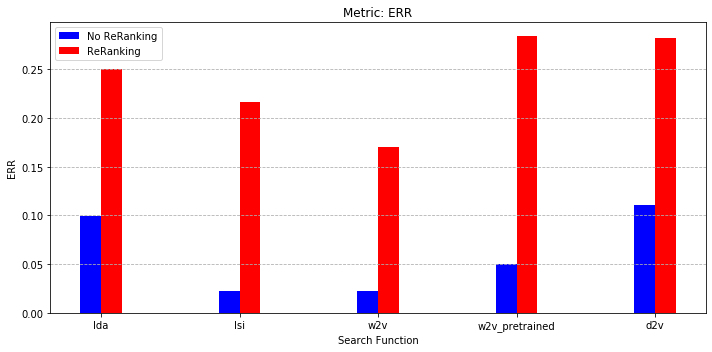

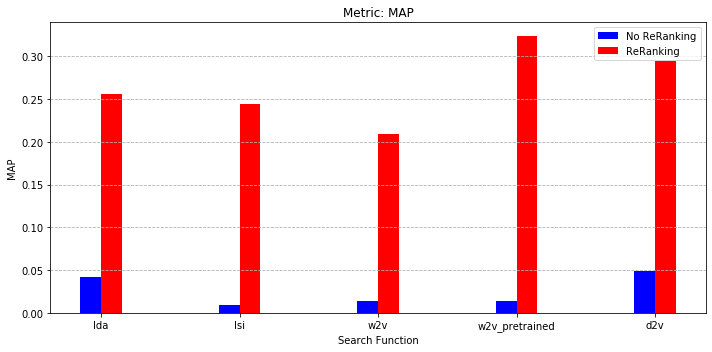

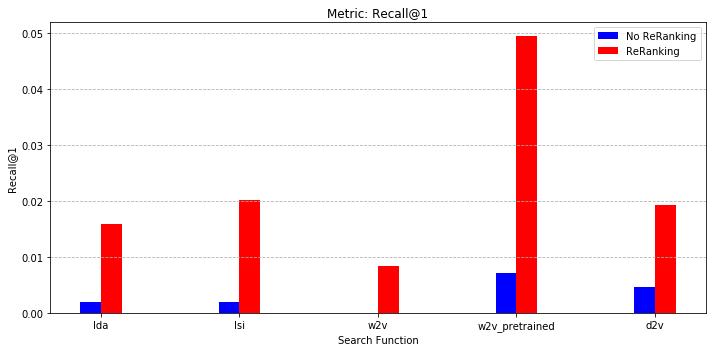

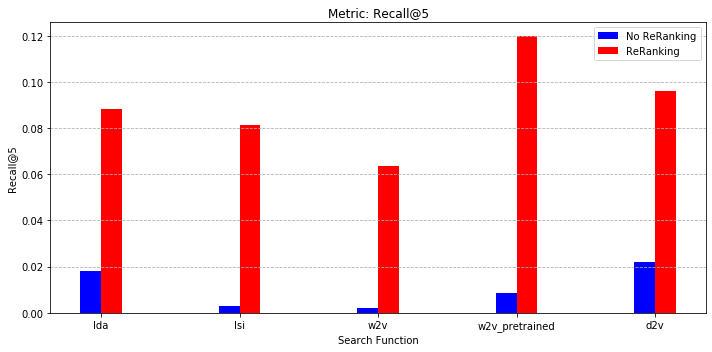

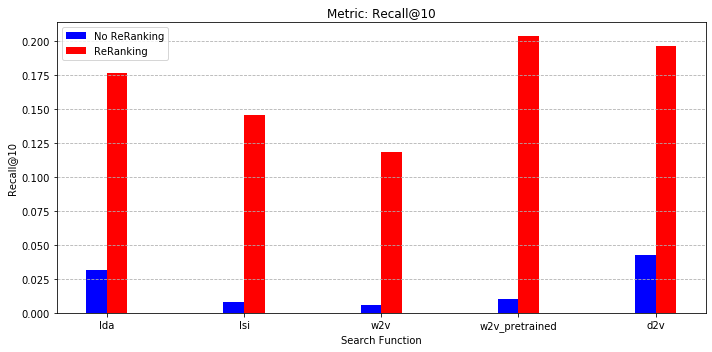

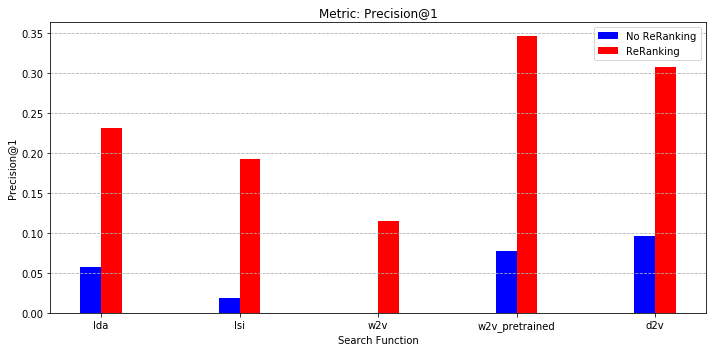

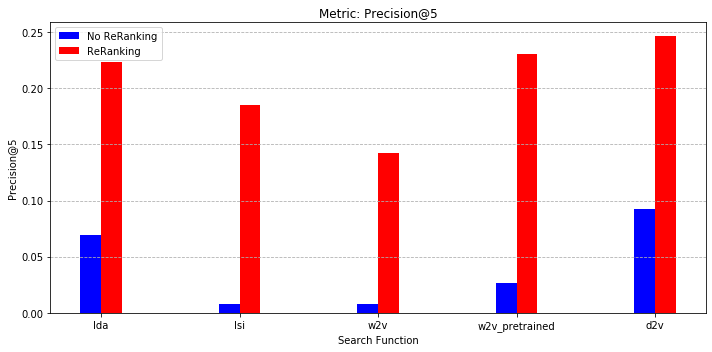

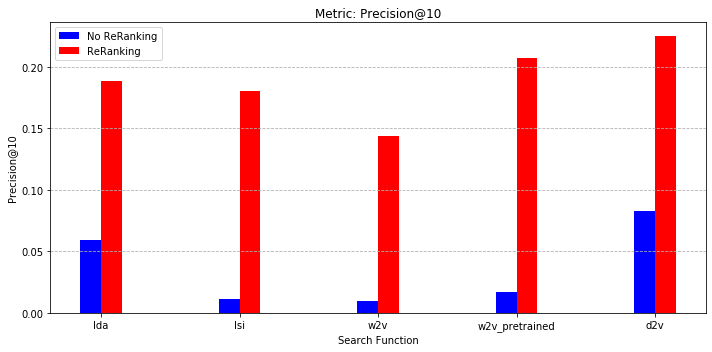

method : BOW with index : 2 {'ERR': 0.11996831, 'MAP': 0.07335121, 'Recall@1': 0.009497121, 'Recall@5': 0.04654979, 'Recall@10': 0.080543, 'Precision@1': 0.07692308, 'Precision@5': 0.080769226, 'Precision@10': 0.07307692}
method : TF-IDF with index : 2 {'ERR': 0.4148428, 'MAP': 0.2847683, 'Recall@1': 0.08998284, 'Recall@5': 0.21299928, 'Recall@10': 0.2675624, 'Precision@1': 0.53846157, 'Precision@5': 0.33846155, 'Precision@10': 0.25}
method : NaiveQL with index : 2 {'ERR': 0.10249472, 'MAP': 0.06903334, 'Recall@1': 0.009866221, 'Recall@5': 0.028808113, 'Recall@10': 0.047993064, 'Precision@1': 0.13461539, 'Precision@5': 0.080769226, 'Precision@10': 0.067307696}
method : QL with index : 2 {'ERR': 0.40624025, 'MAP': 0.26480663, 'Recall@1': 0.06592906, 'Recall@5': 0.19856308, 'Recall@10': 0.2835027, 'Precision@1': 0.5192308, 'Precision@5': 0.3692308, 'Precision@10': 0.29807693}
method : BM25 with index : 2 {'ERR': 0.426171, 'MAP': 0.33066702, 'Recall@1': 0.10448813, 'Recall@5': 0.23509185,

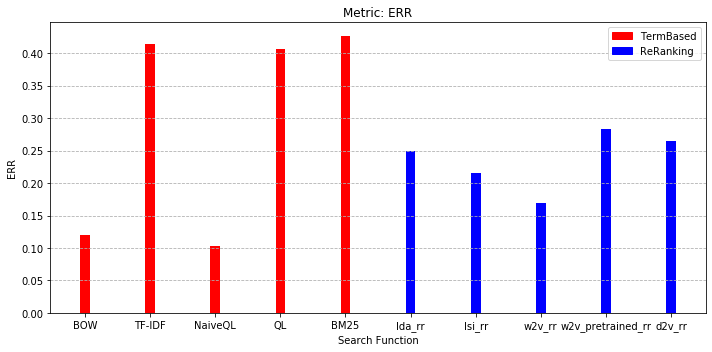

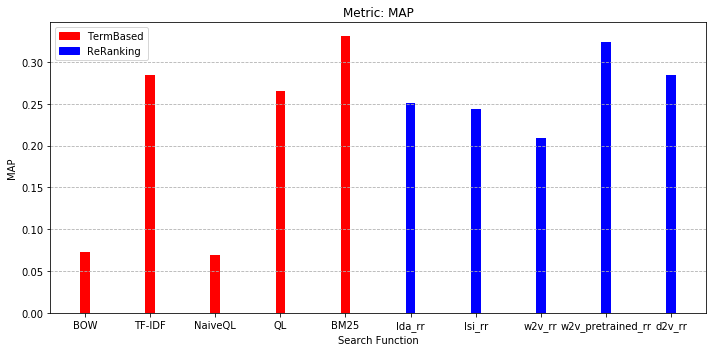

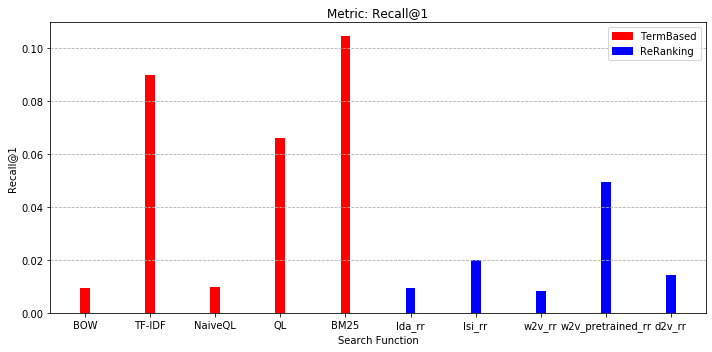

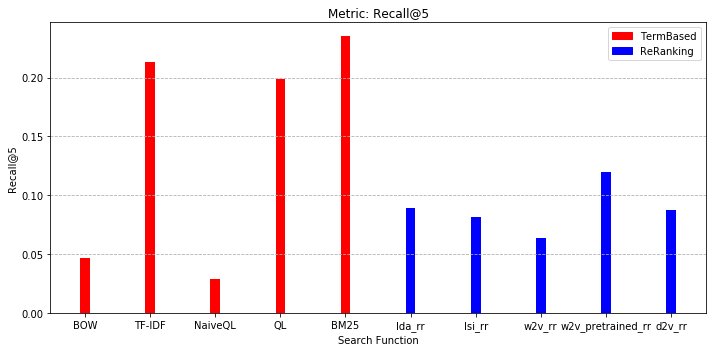

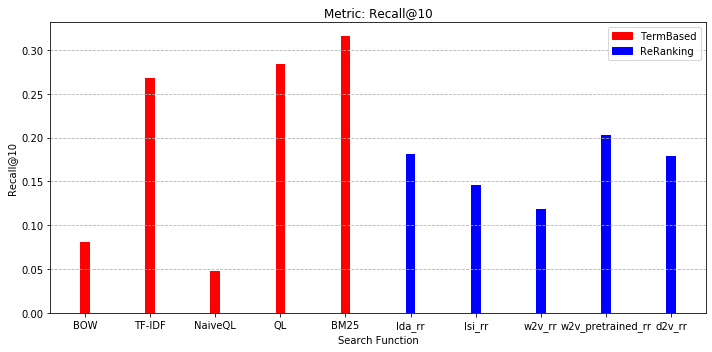

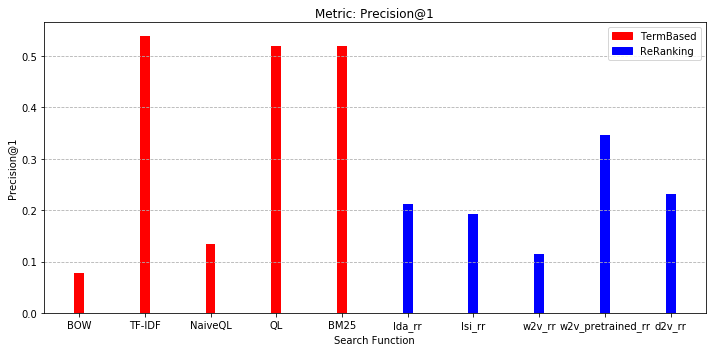

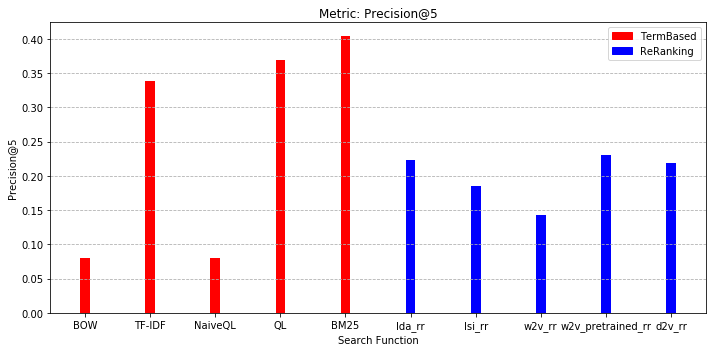

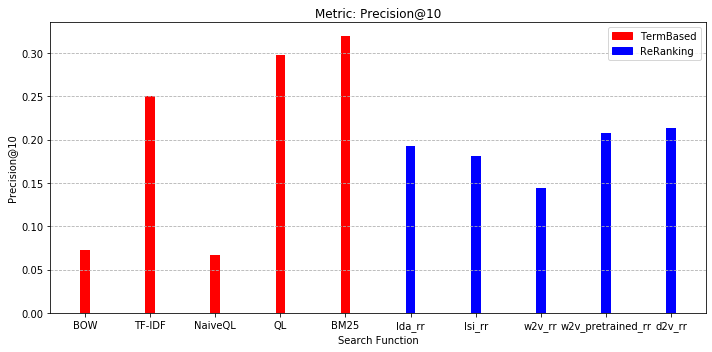

In [101]:
list_of_sem_search_fns = [
    ("lda", drm_lda.search),
    ("lsi", drm_lsi.search),
    ("w2v", drm_w2v.search),
    ("w2v_pretrained", drm_w2v_pretrained.search),
    ("d2v", drm_d2v.search),
    ("lda_rr", lda_rerank.search),
    ("lsi_rr", lsi_rerank.search),
    ("w2v_rr", w2v_rerank.search),
    ("w2v_pretrained_rr", w2v_pretrained_rerank.search),
    ("d2v_rr", d2v_rerank.search),
    
]

# YOUR CODE HERE
import matplotlib.patches as mpatches
data = []
for method, method_fn in list_of_sem_search_fns:
    dictionary = evaluate_search_fn(method_fn, list_of_metrics)
    print(f'method : {method}' " " 'with' " " f'index : {index}', dictionary)
    print('================================================================')
    values = list(dictionary.values())
    data.append(values)

metrics = list(dictionary.keys())
X = np.arange(len(list_of_sem_search_fns)/2)
bar_width = 0.15

bars = []
rr_bars = []
#plot result for each metric
for i, metric in enumerate(metrics):
    fig = plt.figure(figsize=(10,5))
    for search_function in list_of_sem_search_fns[:5]:
        bars.append(plt.bar(X + i * bar_width - bar_width/2, [methods[i] for methods in data[:5]], bar_width, label='No ReRanking', color='b'))
    for search_function in list_of_sem_search_fns[5:]:
        rr_bars.append(plt.bar(X + i * bar_width + bar_width/2, [methods[i] for methods in data[5:]], bar_width, label='ReRanking', color='r'))

    plt.xticks(X + i * bar_width , [method[0] for method in list_of_sem_search_fns[:5]])
    plt.legend([tuple(bars), tuple(rr_bars)], ('No ReRanking', 'ReRanking'))
    plt.title(f'Metric: {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('Search Function')
    plt.grid(axis = 'y', linestyle = '--')
    fig.tight_layout()
    plt.show()
    
#----------------------------------------Comparisons_with_part1----------------------------------------#
list_of_search_fns = [
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search),
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search),
    
    ("lda_rr", lda_rerank.search),
    ("lsi_rr", lsi_rerank.search),
    ("w2v_rr", w2v_rerank.search),
    ("w2v_pretrained_rr", w2v_pretrained_rerank.search),
    ("d2v_rr", d2v_rerank.search)
]

red_patch = mpatches.Patch(color='r', label='TermBased')
blue_patch = mpatches.Patch(color='b', label='ReRanking')

data = []
it = 0
for method, method_fn in list_of_search_fns:
    if it < 5:
        dictionary = evaluate_search_fn(method_fn, list_of_metrics, 2)
    else:
        dictionary = evaluate_search_fn(method_fn, list_of_metrics)
    print(f'method : {method}' " " 'with' " " f'index : {index}', dictionary)
    print('================================================================')
    values = list(dictionary.values())
    data.append(values)
    it += 1

metrics = list(dictionary.keys())
X = np.arange(len(list_of_search_fns))
bar_width = 0.15

bars = []
#plot result for each metric
for i, metric in enumerate(metrics):
    fig = plt.figure(figsize=(10,5))
    for search_function in list_of_search_fns:
        bars.append(plt.bar(X + i * bar_width, [methods[i] for methods in data], bar_width, color=['r', 'r', 'r', 'r', 'r', 'b', 'b', 'b', 'b', 'b']))

    plt.xticks(X + i * bar_width , [method[0] for method in list_of_search_fns])
    plt.legend(handles=[red_patch, blue_patch])
    plt.title(f'Metric: {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('Search Function')
    plt.grid(axis = 'y', linestyle = '--')
    fig.tight_layout()
    plt.show()

### Section 10.2: Summary (20 points)

Your summary should compare methods from Part 1 and Part 2 (only for index set 2). State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations. Consider the availability of data, scalability, domain/type of data, etc.

In the previous section, we created two different types of plots for each one of the used metrics (i.e. ERR, MAP, Recall@1, Recall@5, Recall@10, precision@1, Precision@5, Precision@10). In the first block of plots, we compare each one of the methods with its ReRanking option. It is clear that for all the metrics the ReRanking model outperforms the corresponding model without ReRanking. It is now clear that the ReRanking process not only makes retrieval faster, but semantic methods perform poorly when used in isolation.

The Word2Vec has the worst performance independently of the used metric, while the Pretrained Word2Vec has the best performance in most cases. This behavior is expected as Word2Vec is used for word representations in vector space, which get averaged through the whole document finally. Word2Vec cannot handle out-of-vocabulary words well, as it assigns a random vector representation for OOV words which can be suboptimal. Furthermore, it requires a comparatively larger corpus for the network to converge. In our case, we have a pretty small dataset which also missing the abstract for some documents. As we can observe from the above plots, using a pre-trained Word2Vec we can address these problems achieving better performances.

The rest semantic methods (i.e. LSI, LDA, Doc2Vec) perform similar behavior, except for Recall@1 and Recall@5. In more detail, we can observe that Doc2Vec outperforms the other two and LDA outperforms LSI for all metrics except for the previously referred ones (which can be explained by the same reason mentioned in section 5.2: as the variability of the results increases when the rank decreases, it may be the case that, for recall at rank 1 and 5, LSI outperforms LDA by chance, while for the larger ranks the results converge to the expected scenario, namely LDA scoring better than LSI). The above observation can also be confirmed theoretically, while doc2vec, based on word2vec, gets word vectors (unsupervised learning), the inference stage to get paragraph vector follows. The third stage is to turn the paragraph vector to predict some particular labels using a standard classifier. Paragraph vector is unique among all documents while word vectors are shared among all documents such that word vectors can be learned from a different document. Furthermore, LSI learns latent topics by performing a matrix decomposition (SVD) on the term-document matrix, while LDA is a generative probabilistic model, that assumes a Dirichlet prior over the latent topics. We can confirm our observations on the LSI and LDA models based on this statement.

We were expecting the semantics models to perform better than the "term-based" models from section 1. However, it seems that this is not the case for our dataset, while BM25 outperforms all other methods for all the metrics. One reason is that our training dataset is very small and thus the semantic models can not learn good latent representations. In addition, because the dataset contains abstracts from a specific domain (ACM) and we are performing query search, most of the words appear in the same context so it is possible to get exact matching between queries and documents. This makes the job of 'term-based' models, which do not care about semantics, easier.  MAP assumes the user is interested in finding many relevant documents for each query and requires many relevance judgments in-text collection, which can also be observed by the above MAP plot where the "term-based" and the "semantic-based" methods are pretty closed. In conclusion, when dealing with more diverse datasets, we would expect the semantics models to have an advantage by incorporating semantics.